In [1]:
from SciData import*
import pathlib
cwp = str(pathlib.Path().absolute())
def is_close(num_list:list,match_num:float,precision = 1e-6)->bool:
    return [abs(num-match_num)<precision for num in num_list]
e0 = 1.6021766208E-19 # The elementary charge
h0 = 6.62607015E-34 # The Planck's constant

def range_pick(yourlist,lb,ub):
    lb_set = yourlist>lb
    ub_set = yourlist<ub
    chosen_set = [all([x,y]) for x,y in zip(lb_set,ub_set)]
    return chosen_set


def pos_neg(num):
    if num>0:
        return 1
    else:
        return -1
    
def read_file(directory):
    filenames = dir2fnm(directory)
    num_list = [0]*len(filenames)
    for i,fnm in enumerate(filenames):
        fnm_strip = fnm.split()
        fnm_strip = fnm_strip[-2].split('d')
        num_str = fnm_strip[-1].replace('T','').replace(',','.')
        num_list[i] = float(num_str)
    return num_list


def set_pub():
    plt.rc('lines', lw=1, color='k') # thicker black lines
    plt.rc('grid', c='0.5', ls='-', lw=0.5)  # solid gray grid lines
    plt.rc('savefig', dpi=600)       # higher res outputs
    plt.rc("font", size=25, family='arial', weight='light')
    plt.rc("axes", labelsize=25, titlesize=25,linewidth=1)
    plt.rc("xtick", direction = 'in',labelsize = 25)
    plt.rc('xtick.major', size=10, pad=7)
    plt.rc('xtick.minor', size=5, pad=7, visible=True)
    plt.rc("ytick", direction = 'in',labelsize = 25)
    plt.rc('ytick.major', size=10, pad=7)
    plt.rc('ytick.minor', size=5, pad=7,visible=True)
    plt.rc("legend", fontsize=25)
    plt.rc('lines',linewidth = 2)

set_pub()

def LL_energy(B_tot, B_perp,N,gfactor,vf): # N = 0,1,2,3...
    return (2*e0*hbar*vf**2*B_perp*N+(gfactor*muB*B_tot)**2)**0.5
    
def LL_fillfactor(fermi_energy,LLenergy:list):
    index = 0
    while fermi_energy>LLenergy[index]:
        if index == len(LLenergy)-1:
            break
        else:
            index = index+1
    return index-0.5

def density2energy(density,vf):
    return hbar*vf*(4*np.pi*density)**0.5

def add_sxy(sxy1:list,sxy2:list)->list:
    if len(sxy1)!=len(sxy2):
        print('Not the same length!')
    else:
        return[sxy1[idx]+sxy2[idx] for idx in range(len(sxy1))]
print('Welcome.')

Welcome.


# Landau fan model
This is a descrition of how to build a Landau fan consisting of two surface states and an additional, parabolic bands.

STEP ONE

The energy of Laudau levels is determined by the Hamiltonian and Laudau gauge: it differs in Dirac-type and parabolic bands.

For Dirac-type,
$E(B,N) = \sqrt{2e\hbar v_f^2B_pN+(g\mu_BB)^2}$ in which $N$ is the so-called Landau index, the eigenvalue of $a^{+}a$.

For parabolic band, 
$E(B,N,s) = (N+\frac{1}{2})\hbar eB/m\pm g\mu_BB/2$ in $\pm$ stands for two spin orientations.

STEP TWO

The energy at $B=0$ for all the Landau levels is determined by the band dispersion, which we should assume reasonable values according to the pratical situation. Here we name top and botttom surface states and the closest VPS as T,B,V. We can initate the energy as $E_T$,$E_B$,$E_V$ respectively.

STEP THREE

Due to the former steps, we now can calculate the density of state DOS as a function of energy E. Here we can introduce a Gaussian distribution $N_df(E) = \frac{N_d}{\sigma \sqrt{2\pi}}e^{-0.5(\frac{E-E_{LL}}{\sigma})^2}$ to reflect the broadening of Landau level due to impurities. Set the energy window of interest ($E_1$,$E_2$). The code needs to add up all the Gaussian function at different energy $E_{LL}$ at a fixed magnetic field $B$.

STEP FOUR

With obtained DOS(E) function, we can start to fill the states given a certain density $n$ ($n>0$ means electron density > hole density). After introduction of LL broadening, the DOS(E) funtion is monotonic, thus the energy can be deduced by giving the density. 




In [3]:
from scipy.integrate import quad

# physical constants

e0 = 1.60217662e-19
h0 = 6.62607015e-34
hbar = h0/np.pi/2
muB = -9.284764e-24
me = 9.109e-31
# function

def boolean_fun(x):
    if x == True:
        return 1
    else:
        return 0

def llenergy_dirac(B,B_perp,N,vf=1e6,gfactor=28):
    if N>0:
        return (2*e0*hbar*vf**2*B_perp*N+(gfactor*muB*B)**2)**0.5
    elif N == 0:
        return -gfactor*muB*B
    else:
        return -(2*e0*hbar*vf**2*B_perp*(-N)+(gfactor*muB*B)**2)**0.5


def llenergy_conv(B,B_perp,N,s,meff,gfactor=6):
    if s==1:
        return (N+0.5)*hbar*e0*B_perp/me/meff+gfactor*muB*B/2
    else:
        return (N+0.5)*hbar*e0*B_perp/me/meff-gfactor*muB*B/2
    
    
def llenergy_generator(Ets,Ebs,Evp,B,angle,meff,Nmax=30,vf=1e6,gfactor=28):
    
    llenergy_top_surface = [Ets+llenergy_dirac(B,B*np.cos(angle*np.pi/180),N,vf,gfactor) for N in range(Nmax-1)]
    llenergy_bottom_surface = [Ebs+llenergy_dirac(B,B*np.cos(angle*np.pi/180),N,vf,gfactor) for N in range(Nmax-1)]
    llenergy_vps_up = [Evp+llenergy_conv(B,B*np.cos(angle*np.pi/180),N,1,meff) for N in range(Nmax-1)]
    llenergy_vps_down = [Evp+llenergy_conv(B,B*np.cos(angle*np.pi/180),N,-1,meff) for N in range(Nmax-1)]

    return llenergy_top_surface,llenergy_bottom_surface,llenergy_vps_up,llenergy_vps_down

# define a container for passing on frequently used global arguments
class TBLLsimu ():
        def __init__(self,vf,gfactor,sigma,meff):
            self.vf = vf
            self.gfactor = gfactor
            self.sigma = sigma
            self.meff = meff
            
            
        def __repr__(self):
            return f'TBLLsimu(vf = {self.vf},gfactor = {self.gfactor},sigma = {self.sigma},meff = {self.meff}))'
            
        def get_ll_en(self,angle,Brange,Nmax,den_top,den_bot,den_vps=None,threeband=False):
            
            vf = self.vf
            sigma = self.sigma
            gfactor = self.gfactor
            meff = self.meff
            
            Ets = -hbar*vf*(4*np.pi*den_top)**0.5
            Ebs = -hbar*vf*(4*np.pi*den_bot)**0.5
            
            
            LLenergy_top_surface = []
            LLenergy_bottom_surface = []
            
            if threeband:
                Evp = -hbar**2*den_vps*np.pi/(meff*me)/2
                LLenergy_vps_up = []
                LLenergy_vps_down = []
                
                for B in Brange:
                    llenergy_top_surface,llenergy_bottom_surface,llenergy_vps_up,llenergy_vps_down = llenergy_generator(Ets,Ebs,Evp,B,angle,meff,Nmax,vf,gfactor)
                    LLenergy_top_surface.append(llenergy_top_surface)
                    LLenergy_bottom_surface.append(llenergy_bottom_surface)
                    LLenergy_vps_up.append(llenergy_vps_up)
                    LLenergy_vps_down.append(llenergy_vps_down)
                return LLenergy_top_surface,LLenergy_bottom_surface,LLenergy_vps_up,LLenergy_vps_down
            
            else:

                for B in Brange:
                    llenergy_top_surface,llenergy_bottom_surface,_,_ = llenergy_generator(Ets,Ebs,0,B,angle,meff,Nmax,vf,gfactor)
                    LLenergy_top_surface.append(llenergy_top_surface)
                    LLenergy_bottom_surface.append(llenergy_bottom_surface)
            
                return LLenergy_top_surface,LLenergy_bottom_surface   
        
        def get_ll_den(self,angle,Brange,Erange,Nmax,den_top,den_bot,den_vps=None,threeband=False):
            
            vf = self.vf
            sigma = self.sigma
            gfactor = self.gfactor
            meff = self.meff

            N_top_surface = []
            N_bottom_surface = []
            if threeband:
                
                LLenergy_top_surface,LLenergy_bottom_surface,LLenergy_vps_up,LLenergy_vps_down = self.get_ll_en(angle,Brange,Nmax,den_top,den_bot,den_vps,threeband)
                IDOS = self.IDOS_generator(angle,Brange,Erange,LLenergy_top_surface,LLenergy_bottom_surface,LLenergy_vps_up,LLenergy_vps_down)
                N_vps_up = []
                N_vps_down = []
    
                for LLenergy,LLn in zip([LLenergy_top_surface,LLenergy_bottom_surface,LLenergy_vps_up,LLenergy_vps_down],
                                    [N_top_surface,N_bottom_surface,N_vps_up,N_vps_down]):
                    for index, ll in enumerate(LLenergy):
                        IDOS_B = IDOS[index]
                        LLn.append([np.interp(x=x,xp=Erange,fp=IDOS_B) for x in ll])

                return N_top_surface,N_bottom_surface,N_vps_up,N_vps_down
            
            else:

                LLenergy_top_surface,LLenergy_bottom_surface = self.get_ll_en(angle,Brange,Nmax,den_top,den_bot,den_vps,threeband)                
                IDOS = self.IDOS_generator(angle,Brange,Erange,LLenergy_top_surface,LLenergy_bottom_surface)
                for LLenergy,LLn in zip([LLenergy_top_surface,LLenergy_bottom_surface],
                                    [N_top_surface,N_bottom_surface]):
                    for index, ll in enumerate(LLenergy):
                        IDOS_B = IDOS[index]
                        LLn.append([np.interp(x=x,xp=Erange,fp=IDOS_B) for x in ll])
                        
                return N_top_surface,N_bottom_surface
            
        def plot_ll_en(self,angle,Brange,Erange,Nmax,den_top,den_bot,den_vps=None,threeband=False):
            
            
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            
            if threeband:
                    
                    LL_ts,LL_bs,LL_vpsup,LL_vpsdown=self.get_ll_en(angle,Brange,Nmax,den_top,den_bot,den_vps,threeband)
                    IDOS = self.IDOS_generator(angle,Brange,Erange,LL_ts,LL_bs,LL_vpsup,LL_vpsdown)
                    ax.plot(Brange,[find_energy_bydensity(den_top+den_bot-den_vps,B,IDOS_B,Erange)*1e3/e0 for B,IDOS_B in zip(Brange,IDOS)],linewidth=1,color='k')
                    


                    for ll_ts in np.transpose(LL_ts):
                        ax.plot(Brange,ll_ts*1e3/e0,'r-')
                    for ll_bs in np.transpose(LL_bs):
                        ax.plot(Brange,ll_bs*1e3/e0,'b-')
                    for ll_vpsup in np.transpose(LL_vpsup):
                        ax.plot(Brange,ll_vpsup*1e3/e0,'k-')
                    for ll_vpsdown in np.transpose(LL_vpsdown):
                        ax.plot(Brange,ll_vpsdown*1e3/e0,'y-')
                        
            else:
                    LL_ts,LL_bs=self.get_ll_en(angle,Brange,Nmax,den_top,den_bot,den_vps,threeband)
                    IDOS = self.IDOS_generator(angle,Brange,Erange,LL_ts,LL_bs)
#                     [ax.plot(Brange,[find_energy_bydensity(den,B,IDOS_B,Erange)*1e3/e0 for B,IDOS_B in zip(Brange,IDOS)],linewidth=1,color='g',linestyle='--') for den in np.linspace(1e15,1e16,10)]
                    ax.plot(Brange,[find_energy_bydensity(den_top+den_bot,B,IDOS_B,Erange)*1e3/e0 for B,IDOS_B in zip(Brange,IDOS)],linewidth=1,color='k')
                    for ll_ts in np.transpose(LL_ts):
                        ax.plot(Brange,ll_ts*1e3/e0,'r-')
                    for ll_bs in np.transpose(LL_bs):
                        ax.plot(Brange,ll_bs*1e3/e0,'b-')
             
            ax.set_ylim([-10,30])
            ax.set_xlabel('B (T)')
            ax.set_ylabel('Energy (meV)')
            return fig,ax
        
        def plot_ll_den(self,angle,Brange,Erange,Nmax,den_top,den_bot,den_vps=None,threeband=False):

            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            if threeband:
                    N_ts,N_bs,N_vpsup,N_vpsdown=self.get_ll_den(angle,Brange,Erange,Nmax,den_top,den_bot,den_vps,threeband)
                    ax.axhline(y=(den_top+den_bot-den_vps)/1e15,linewidth=1)
                    for n_ts in np.transpose(N_ts):
                        ax.plot(Brange,n_ts/1e15,'r-')
                    for n_bs in np.transpose(N_bs):
                        ax.plot(Brange,n_bs/1e15,'b-')
                    for n_vpsup in np.transpose(N_vpsup):
                        ax.plot(Brange,n_vpsup/1e15,'k-')
                    for n_vpsdown in np.transpose(N_vpsdown):
                        ax.plot(Brange,n_vpsdown/1e15,'y-')
                        
            else:
                    N_ts,N_bs=self.get_ll_den(angle,Brange,Erange,Nmax,den_top,den_bot,den_vps,threeband)
                    ax.axhline(y=(den_top+den_bot)/1e15,linewidth=1)
                    for n_ts in np.transpose(N_ts):
                        ax.plot(Brange,n_ts/1e15,'r-')
                    for n_bs in np.transpose(N_bs):
                        ax.plot(Brange,n_bs/1e15,'b-')
            ax.set_ylim(-4,4)
            ax.set_xlabel('B (T)')
            ax.set_ylabel('Density ($10^{11}cm^{-2}$)')
            return fig,ax       

        def IDOS_generator(self,angle,Brange,Erange,LLenergy_top_surface,LLenergy_bottom_surface,LLenergy_vps_up=None,LLenergy_vps_down=None):
            sigma = self.sigma
            IDOS = []

            if all([LLenergy_vps_up,LLenergy_vps_down]):
                for B,llenergy_top_surface,llenergy_bottom_surface,llenergy_vps_up,llenergy_vps_down in zip(Brange,LLenergy_top_surface,LLenergy_bottom_surface,LLenergy_vps_up,LLenergy_vps_down):

                    IDOS_B = [x+y for x, y in zip(fastIntegral_electron_DOS(Erange,B,sigma,angle,llenergy_top_surface,llenergy_bottom_surface),
                                  fastIntegral_hole_DOS(Erange,B,sigma,angle,llenergy_vps_up,llenergy_vps_down))]
                    IDOS.append(IDOS_B)
            else:
                for B,llenergy_top_surface,llenergy_bottom_surface in zip(Brange,LLenergy_top_surface,LLenergy_bottom_surface):

                    IDOS_B = fastIntegral_electron_DOS(Erange,B,sigma,angle,llenergy_top_surface,llenergy_bottom_surface)
                    IDOS.append(IDOS_B)

            return IDOS
        
        def plot_DOS(self,angle,Bfield,Erange,Nmax,den_top,den_bot,den_vps=None,threeband=False):
           
            vf = self.vf
            sigma = self.sigma
            gfactor = self.gfactor
            meff = self.meff
            
            Ets = -hbar*vf*(4*np.pi*den_top)**0.5
            Ebs = -hbar*vf*(4*np.pi*den_bot)**0.5
            lldegeneracy = Bfield*np.cos(angle*np.pi/180)*e0/h0
            
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            
            if threeband:
                Evp = -hbar**2*den_vps*np.pi/(meff*me)/2
                llenergy_top_surface,llenergy_bottom_surface,llenergy_vps_up,llenergy_vps_down = llenergy_generator(Ets,Ebs,Evp,Bfield,angle,meff,Nmax,vf,gfactor)
                
                ax.fill_between(1e3*Erange/e0,[electron_density_of_state(E,Bfield,sigma,angle,llenergy_top_surface,[]) for E in Erange],0,color='r',alpha=0.3)
                ax.fill_between(1e3*Erange/e0,[electron_density_of_state(E,Bfield,sigma,angle,[],llenergy_bottom_surface) for E in Erange],0,color='b',alpha=0.3)
                ax.fill_between(1e3*Erange/e0,[hole_density_of_state(E,Bfield,sigma,angle,llenergy_vps_up,[]) for E in Erange],0,color='k',alpha=0.3)
                ax.fill_between(1e3*Erange/e0,[hole_density_of_state(E,Bfield,sigma,angle,[],llenergy_vps_down) for E in Erange],0,color='y',alpha=0.3)

                      
            else:
                
                llenergy_top_surface,llenergy_bottom_surface,_,_ = llenergy_generator(Ets,Ebs,0,Bfield,angle,meff,Nmax,vf,gfactor)
                ax.fill_between(1e3*Erange/e0,[electron_density_of_state(E,Bfield,sigma,angle,llenergy_top_surface,[]) for E in Erange],0,color='r',alpha=0.3)
                ax.fill_between(1e3*Erange/e0,[electron_density_of_state(E,Bfield,sigma,angle,[],llenergy_bottom_surface) for E in Erange],0,color='b',alpha=0.3)
            
            ax.set_xlabel('Energy (meV)')
            return fig,ax
        
        def plot_muDOS(self,angle,Brange,Erange,Nmax,den_top,den_bot,den_vps=None,threeband=False):
            
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            sigma = self.sigma
            
            if threeband:
                    
                    LL_ts,LL_bs,LL_vpsup,LL_vpsdown=self.get_ll_en(angle,Brange,Nmax,den_top,den_bot,den_vps,threeband)
                    IDOS = self.IDOS_generator(angle,Brange,Erange,LL_ts,LL_bs,LL_vpsup,LL_vpsdown)
                    mu = [find_energy_bydensity(den_top+den_bot-den_vps,B,IDOS_B,Erange) for B,IDOS_B in zip(Brange,IDOS)]
                    ax.plot(Brange,[electron_density_of_state(E,B,sigma,angle,ll_ts,[]) for E,B,ll_ts in zip(mu,Brange,LL_ts)],linewidth=1,color='r')
                    ax.plot(Brange,[electron_density_of_state(E,B,sigma,angle,[],ll_bs) for E,B,ll_bs in zip(mu,Brange,LL_bs)],linewidth=1,color='b')
                    ax.plot(Brange,[hole_density_of_state(E,B,sigma,angle,ll_up,[]) for E,B,ll_up in zip(mu,Brange,LL_vpsup)],linewidth=1,color='k')
                    ax.plot(Brange,[hole_density_of_state(E,B,sigma,angle,[],ll_down) for E,B,ll_down in zip(mu,Brange,LL_vpsdown)],linewidth=1,color='y')
                    
            else:
                    LL_ts,LL_bs=self.get_ll_en(angle,Brange,Nmax,den_top,den_bot,den_vps,threeband)
                    IDOS = self.IDOS_generator(angle,Brange,Erange,LL_ts,LL_bs)
                    mu = [find_energy_bydensity(den_top+den_bot,B,IDOS_B,Erange) for B,IDOS_B in zip(Brange,IDOS)]
                    ax.plot(Brange,[electron_density_of_state(E,B,sigma,angle,ll_ts,[]) for E,B,ll_ts in zip(mu,Brange,LL_ts)],linewidth=1,color='r')
                    ax.plot(Brange,[electron_density_of_state(E,B,sigma,angle,[],ll_bs) for E,B,ll_bs in zip(mu,Brange,LL_bs)],linewidth=1,color='b')
                    ax.plot(Brange,[electron_density_of_state(E,B,sigma,angle,ll_ts,ll_bs)for E,B,ll_ts,ll_bs in zip(mu,Brange,LL_ts,LL_bs)],linewidth=2,color='k',linestyle='--')

            return fig,ax

# def Gaussian_broadening(energy,sigma,energy_center,lldegeneracy):
#     return lldegeneracy*np.exp(-0.5*(energy-energy_center)**2/sigma**2)/sigma/(2*np.pi)**0.5

def electron_density_of_state(E,B,sigma,angle,llenergy_top_surface,llenergy_bottom_surface):
            
        electron_density_of_state = []
        
        
        lldegeneracy = B*np.cos(angle*np.pi/180)*e0/h0
        
        for ll in llenergy_top_surface+llenergy_bottom_surface:
            electron_density_of_state.append(lldegeneracy*np.exp(-0.5*(E-ll)**2/sigma**2)/sigma/(2*np.pi)**0.5)
            
        if all([llenergy_top_surface,llenergy_bottom_surface]):
            compensate = 0.5*lldegeneracy*np.exp(-0.5*(E-min(llenergy_top_surface))**2/sigma**2)/sigma/(2*np.pi)**0.5+0.5*lldegeneracy*np.exp(-0.5*(E-min(llenergy_bottom_surface))**2/sigma**2)/sigma/(2*np.pi)**0.5 # DOS from 0LL should be half of other LLs.
        elif llenergy_top_surface:
            compensate = 0.5*lldegeneracy*np.exp(-0.5*(E-min(llenergy_top_surface))**2/sigma**2)/sigma/(2*np.pi)**0.5
        elif llenergy_bottom_surface:
            compensate = 0.5*lldegeneracy*np.exp(-0.5*(E-min(llenergy_bottom_surface))**2/sigma**2)/sigma/(2*np.pi)**0.5
        else:
            print('Laudau levels can not be both empty!')
        return sum(electron_density_of_state)-compensate

    
def hole_density_of_state(E,B,sigma,angle,llenergy_vps_up,llenergy_vps_down):
    
        hole_density_of_state = []
        
        lldegeneracy = B*np.cos(angle*np.pi/180)*e0/h0
        
        for ll in llenergy_vps_up+llenergy_vps_down:
            hole_density_of_state.append(-lldegeneracy*np.exp(-0.5*(E-ll)**2/(3*sigma)**2)/(3*sigma)/(2*np.pi)**0.5)
            
        return sum(hole_density_of_state)   
            



def Integral_electron_DOS(E,B,sigma,angle,llenergy_top_surface,llenergy_bottom_surface):
    lowest_energy = min(llenergy_top_surface+llenergy_bottom_surface)
    # it is crucial to integrate from lowest_energy-3*sigma to take into account the broadening effect.
    if E>lowest_energy:
        result,_ = quad(electron_density_of_state,lowest_energy-sigma,E,args=(B,sigma,angle,llenergy_top_surface,llenergy_bottom_surface))
        return result 
    else:
        return 0

    
def fastIntegral_electron_DOS(Energy,B,sigma,angle,llenergy_top_surface,llenergy_bottom_surface):    
    lowest_energy = min(llenergy_top_surface+llenergy_bottom_surface)
    output = []
    last_result = 0
    energy_interval = Energy[1]-Energy[0]
    for index, energy in enumerate(Energy):
        if all([energy>lowest_energy-3*sigma+energy_interval,index==0]):
            result,_ = quad(electron_density_of_state,lowest_energy-3*sigma,energy,args=(B,sigma,angle,llenergy_top_surface,llenergy_bottom_surface))         
        elif all([energy>lowest_energy-3*sigma+energy_interval,index>0]):
            result,_ = quad(electron_density_of_state,energy-energy_interval,energy,args=(B,sigma,angle,llenergy_top_surface,llenergy_bottom_surface))       
        elif energy<=lowest_energy-3*sigma:
            result = 0
        else:
            result,_ = quad(electron_density_of_state,lowest_energy-3*sigma,energy,args=(B,sigma,angle,llenergy_top_surface,llenergy_bottom_surface))
           
        result = last_result+result
        output.append(result)
        last_result = result
    return output

def Integral_hole_DOS(E,B,sigma,angle,llenergy_vps_up,llenergy_vps_down):
    highest_energy = max(llenergy_vps_up+llenergy_vps_down)
    # it is crucial to integrate to highest_energy+3*sigma to take into account the broadening effect.
    if E<highest_energy:
        result,_ = quad(hole_density_of_state,highest_energy+3*sigma,E,args=(B,sigma,angle,llenergy_vps_up,llenergy_vps_down))
        return result
    else:
        return 0


def fastIntegral_hole_DOS(Energy,B,sigma,angle,llenergy_vps_up,llenergy_vps_down): 
    highest_energy = max(llenergy_vps_up+llenergy_vps_down)

    output = []
    last_result = 0
    energy_interval = Energy[1]-Energy[0]
    Ennergy_r = Energy.tolist()
    Ennergy_r.reverse()
    for index,energy in enumerate(Ennergy_r):
        if all([energy<highest_energy+3*sigma-energy_interval,index==0]):
            result,_ = quad(hole_density_of_state,energy,highest_energy+3*sigma,args=(B,sigma,angle,llenergy_vps_up,llenergy_vps_down))
        elif all([energy<highest_energy+3*sigma-energy_interval,index>0]):
            result,_ = quad(hole_density_of_state,energy,energy+energy_interval,args=(B,sigma,angle,llenergy_vps_up,llenergy_vps_down))        
        elif energy>=highest_energy+3*sigma:
            result = 0
        else:
            result,_ = quad(hole_density_of_state,energy,highest_energy+3*sigma,args=(B,sigma,angle,llenergy_vps_up,llenergy_vps_down))
            
        result = last_result+result
        output.append(result)
        last_result = result
    output.reverse()
    return output

    
def find_energy_bydensity(target_density,B,IDOS_B,energy):

    return np.interp(x=target_density,xp=IDOS_B,fp=energy)



Here it can normally function by giving the plot of E-B and density-B relation. 

The next forwarding step is to calculate the quantum Hall plateau and its dependence on the tilt angle.


$\sigma_{xy}$ =Number of occupied Landau levels $\times$ $e^2/h$ at a fixed density.

We can seperately set the density of each surfaces/bands, then set the hole band $E_{vp}=0$ and calculate $E_{ts}$ and $E_{bs}$ according to assigned density. Assume when the total density equals zero, both $E_{ts,0} = E_{bs,0}=0$.
To be more specific, $E_{ts,n_{ts}}=-\hbar v_f\sqrt{4\pi n_{ts}}$ and $E_{bs,n_{bs}}=-\hbar v_f\sqrt{4\pi n_{bs}}$. Given density for each bands, the model should be able to calculate out how the chemical potential varies with the magnetic field,i.e. the number of occupied Landau levels below chemical potential as a function of magnetic field. Even though, we have initialized the start density at zero magnetic field, but as the fomation of Landau levels, the density on each surface bands need to be re-calculated by integrating contribution from each Landan band. This result can help to see intutitively how the dynamics of carrier density change as the field increases.

32.5
45
50
57
62
69
74.5
80


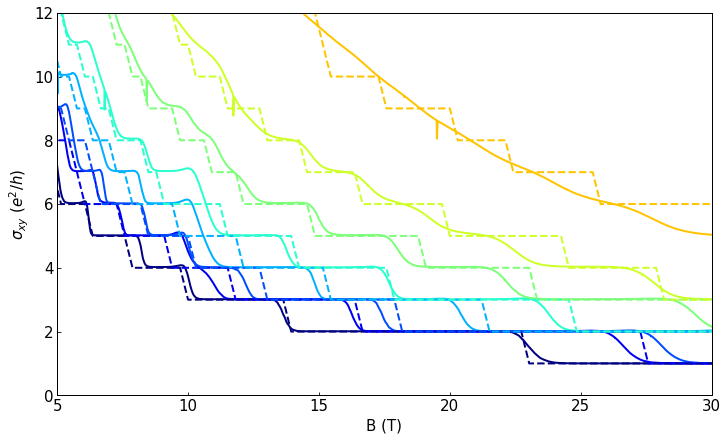

In [373]:
# Experimental data
ref = 9891.6
spr = 0
ucols = (0,1,2,3,4,5,6,7,8)
tot_num = 40
steps = np.linspace(1,tot_num,tot_num)
nms = ['bf','curr_x','curr_y','uxx_x','uxx_y','uxy_x','uxy_y','temp','temp_r']
AspRatio = 3
jet= plt.get_cmap('jet')
c_num = 11

bs_fnm = dir2fnm(r'C:\LAB\Paper\draft_hgmnte\local data\QC0464 AD ICP I\highfield(Grenoble)\Hallmeasurements\Angle dependent measurements')
databundle = pd.DataFrame()
for i in range(len(bs_fnm)):
    
    data = pd.read_csv(bs_fnm[i], sep=" ",skiprows=spr, usecols=ucols, names=nms, header=None)
    if i==0:
        data['rxx'] = (data.uxx_x**2+data.uxx_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*ref
        data['rxy'] = (data.uxy_x**2+data.uxy_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*ref*[pos_neg(x) for x in data.uxy_x]
    else:
        data['rxx'] = (data.uxx_x**2+data.uxx_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5/100
        data['rxy'] = (data.uxy_x**2+data.uxy_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*[pos_neg(x) for x in data.uxy_x]/100
    data['sxx'] = data['rxx']/AspRatio/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['sxy'] = data['rxy']/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['num'] = steps[i]
    databundle = databundle.append(data)
dt = databundle

colors = iter(jet(np.linspace(0,1,c_num)))
fig = plt.figure(figsize=(10,6),constrained_layout=True)
# gs = fig.add_gridspec(2,1)
# ax1,ax2 = [fig.add_subplot(x) for x in gs]
ax1 = fig.add_subplot(111)

for idx,num in enumerate([7,11,15,19,23,27,31,35]):
    color = next(colors)
    ax1.plot(dt[dt.num==num].bf,dt[dt.num==num].sxy,color=color)

ax1.set_ylim(0,12)
ax1.set_xlim(5,30)
[ax.set_xlabel('B (T)') for ax in [ax1]]
[ax.set_ylabel('$\sigma_{xy}$ ($e^2/h$)') for ax in [ax1]]

# simulation for double-QHE systems in tilted magnetic field
qhe_simu = TBLLsimu(vf=0.5e6,gfactor=28,sigma=1e-3*e0,meff=0.1)


Nmax = 20
angles = [32.5,45,50,57,62,69,74.5,80]
# angles = [32.5]
den_top= 5e15
den_bot= 2e15

colors = iter(jet(np.linspace(0,1,c_num)))
Brange=np.linspace(0,30,100)
Erange = np.linspace(-0.03*e0,0.03*e0,60)
for angle in angles:
    color = next(colors)
    
    # generate energy dispersion of Landau levels
    LL_ts,LL_bs = qhe_simu.get_ll_en(angle,Brange,Nmax,den_top,den_bot)
    IDOS = qhe_simu.IDOS_generator(angle,Brange,Erange,LL_ts,LL_bs)

    # the chemical potential as a function of magnetic field, the equal-density line
    chemical_potential = [find_energy_bydensity(den_top+den_bot,x,IDOS_x,energy = Erange) for x,IDOS_x in zip(Brange,IDOS)]

    # count the number of Landau levels from each bands below the chemical potential
    count_ts = []
    count_bs = []
    
    for index,B in enumerate(Brange):

        count_ts.append(sum([boolean_fun(chemical_potential[index]>x) for x in LL_ts[index]]))
        count_bs.append(sum([boolean_fun(chemical_potential[index]>x) for x in LL_bs[index]]))
        
    ax1.plot(Brange,[x+y-1 for x,y in zip(count_bs,count_ts)],color = color,linestyle='--')
    print(angle)
    
    

0
24.58
32.5
45
50
57
62
69
74.5
80


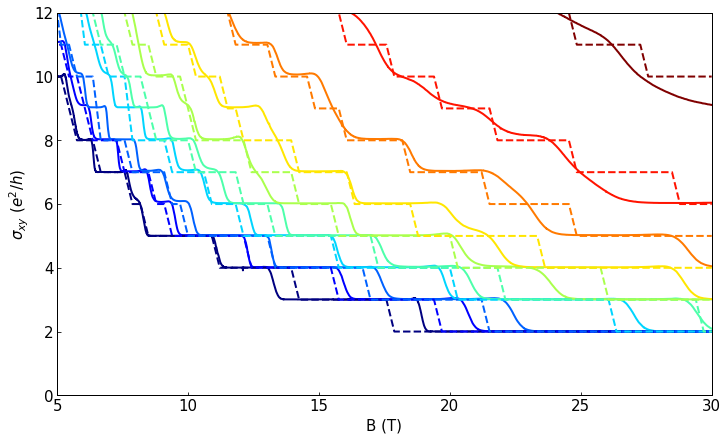

In [377]:
fig = plt.figure(figsize=(10,6),constrained_layout=True)
ax1 = fig.add_subplot(111)
colors = iter(jet(np.linspace(0,1,10)))
for idx,num in enumerate([1,4,6,10,14,18,22,26,30,34]):
    color = next(colors)
    ax1.plot(dt[dt.num==num].bf,dt[dt.num==num].sxy,color=color)

ax1.set_ylim(0,12)
ax1.set_xlim(5,30)
[ax.set_xlabel('B (T)') for ax in [ax1]]
[ax.set_ylabel('$\sigma_{xy}$ ($e^2/h$)') for ax in [ax1]]

# simulation for double-QHE systems in tilted magnetic field
qhe_simu = TBLLsimu(vf=0.5e6,gfactor=28,sigma=1e-3*e0,meff=0.1)


Nmax = 20
angles = [0,24.58,32.5,45,50,57,62,69,74.5,80]
# angles = [32.5]
den_top= 8e15
den_bot= 4e15

colors = iter(jet(np.linspace(0,1,10)))
Brange=np.linspace(0,30,100)
Erange = np.linspace(-0.03*e0,0.03*e0,60)
for angle in angles:
    color = next(colors)
    
    # generate energy dispersion of Landau levels
    LL_ts,LL_bs = qhe_simu.get_ll_en(angle,Brange,Nmax,den_top,den_bot)
    IDOS = qhe_simu.IDOS_generator(angle,Brange,Erange,LL_ts,LL_bs)

    # the chemical potential as a function of magnetic field, the equal-density line
    chemical_potential = [find_energy_bydensity(den_top+den_bot,x,IDOS_x,energy = Erange) for x,IDOS_x in zip(Brange,IDOS)]

    # count the number of Landau levels from each bands below the chemical potential
    count_ts = []
    count_bs = []
    
    for index,B in enumerate(Brange):

        count_ts.append(sum([boolean_fun(chemical_potential[index]>x) for x in LL_ts[index]]))
        count_bs.append(sum([boolean_fun(chemical_potential[index]>x) for x in LL_bs[index]]))
        
    ax1.plot(Brange,[x+y-1 for x,y in zip(count_bs,count_ts)],color = color,linestyle='--')
    print(angle)

(1, 30)

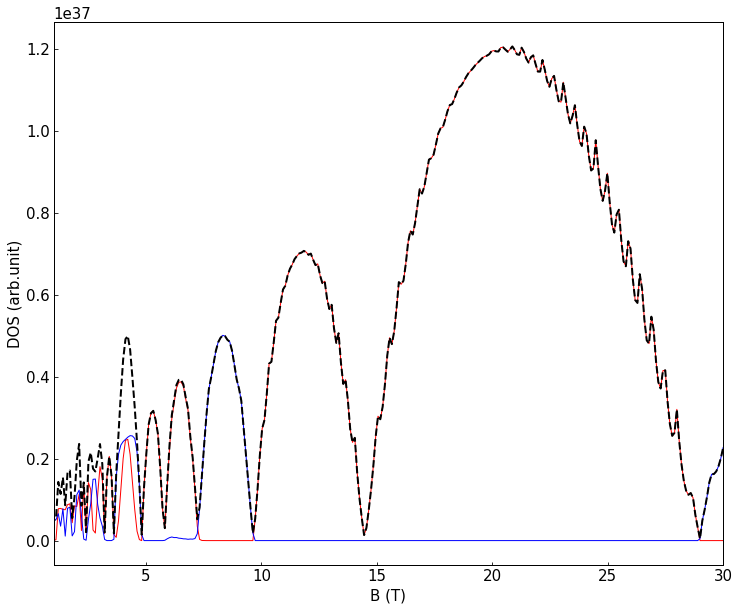

In [319]:
qhe_simu = TBLLsimu(vf=0.5e6,gfactor=28,sigma=1e-3*e0,meff=0.1)
Brange = np.linspace(0,30,300)
Erange = np.linspace(-0.03*e0,0.03*e0,60)
# ax = qhe_simu.plot_DOS(32.5,30,Erange,Nmax,den_top,den_bot)
ax = qhe_simu.plot_muDOS(0,Brange,Erange,20,5e15,2e15)
# ax = qhe_simu.plot_ll_en(0,Brange,Erange,20,5e15,2e15)
# ax.set_ylim(-100,30)
ax.set_ylabel('DOS (arb.unit)')
ax.set_xlabel('B (T)')
ax.set_xlim(1,30)
# ax.set_ylim(-30,10)
# qhe_simu.plot_ll_den(32.5,Brange,Erange,50,5e15,2e15)
# N_top_surface,N_bottom_surface = qhe_simu.get_ll_den(0,Brange,Erange,Nmax,5e15,2e15)
# for i in range(5):    
#     plt.plot(Brange,np.transpose(N_top_surface)[i],'r-')
#     plt.plot(Brange,np.transpose(N_bottom_surface)[i],'b-')

Text(0, 0.5, '$R_{xx}$ or $R_{xy}$ $(\\Omega)$')

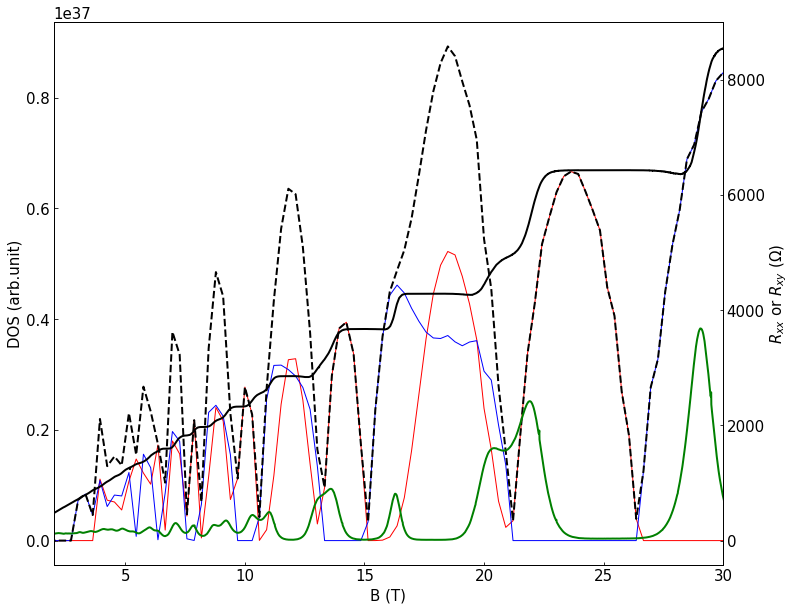

In [372]:
# ref = 9891.6
# spr = 0
# ucols = (0,1,2,3,4,5,6,7,8)
# tot_num = 40
# steps = np.linspace(1,tot_num,tot_num)
# nms = ['bf','curr_x','curr_y','uxx_x','uxx_y','uxy_x','uxy_y','temp','temp_r']
# AspRatio = 3
# jet= plt.get_cmap('jet')
# c_num = 11


# bs_fnm = dir2fnm(r'C:\LAB\Paper\draft_hgmnte\local data\QC0464 AD ICP I\highfield(Grenoble)\Hallmeasurements\Angle dependent measurements')
# databundle = pd.DataFrame()
# for i in range(len(bs_fnm)):
    
#     data = pd.read_csv(bs_fnm[i], sep=" ",skiprows=spr, usecols=ucols, names=nms, header=None)
#     if i==0:
#         data['rxx'] = (data.uxx_x**2+data.uxx_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*ref
#         data['rxy'] = (data.uxy_x**2+data.uxy_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*ref*[pos_neg(x) for x in data.uxy_x]
#     else:
#         data['rxx'] = (data.uxx_x**2+data.uxx_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5/100
#         data['rxy'] = (data.uxy_x**2+data.uxy_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*[pos_neg(x) for x in data.uxy_x]/100
#     data['sxx'] = data['rxx']/AspRatio/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
#     data['sxy'] = data['rxy']/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
#     data['num'] = steps[i]
#     databundle = databundle.append(data)
# dt = databundle
Nmax = 20
Brange = np.linspace(0,30,100)
Erange = np.linspace(-0.03*e0,0.03*e0,60)
qhe_simu = TBLLsimu(vf=0.5e6,gfactor=28,sigma=1e-3*e0,meff=0.1)
# ax = qhe_simu.plot_DOS(angle,10,Erange,Nmax,den_top,den_bot,den_vps,True)
ax = qhe_simu.plot_muDOS(62,Brange,Erange,Nmax,8e15,4e15)
ax1 = ax.twinx()
for idx,num in enumerate([22]):
    ax1.plot(dt[dt.num==num].bf,dt[dt.num==num].rxx,color='g')
    ax1.plot(dt[dt.num==num].bf,dt[dt.num==num].rxy,color='k')
ax.set_xlim(2,30)
ax.set_xlabel('B (T)')
ax.set_ylabel('DOS (arb.unit)')
ax1.set_ylabel('$R_{xx}$ or $R_{xy}$ $(\Omega)$')
# ax1.set_ylim(-500,14000)
# ax1.set_ylim(0,2)

Text(0, 0.5, 'Energy (meV)')

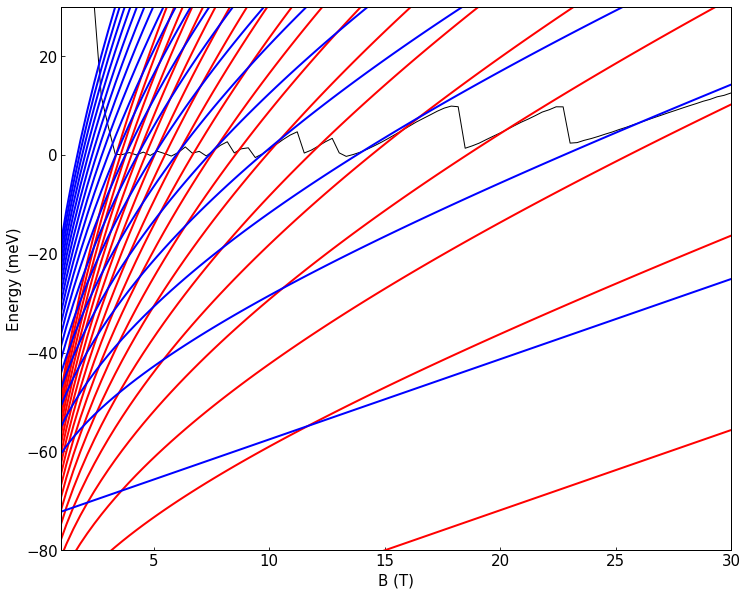

In [371]:
ax = qhe_simu.plot_ll_en(57,Brange,Erange,Nmax,8e15,4e15)
ax.set_ylim(-80,30)
ax.set_xlabel('B (T)')
ax.set_xlim(1,30)
ax.set_ylabel('Energy (meV)')

(0, 2)

C:\Users\lwang\Anaconda\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


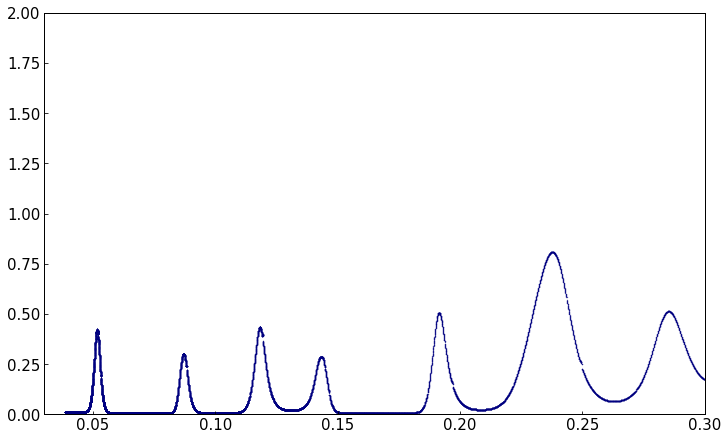

In [4]:
fig = plt.figure(figsize=(10,6),constrained_layout=True)
ax1 = fig.add_subplot(111)
# for idx,num in enumerate([6]):
#     ax1.scatter([1/x for x in dt[dt.num==num].bf],dt[dt.num==num].rxx,color='k',s=1)
    
colors = iter(jet(np.linspace(0,1,c_num)))
for num,angle in zip([7,11,15,19,23],[32.5,45,50,57,62]):
    color = next(colors)
    ax1.scatter([1/x/np.cos(angle/180*np.pi) for x in dt[dt.num==num].bf],dt[dt.num==num].sxx,color=color,s=0.1)
ax1.set_xlim(0.03,0.3)
ax1.set_ylim(0,2)

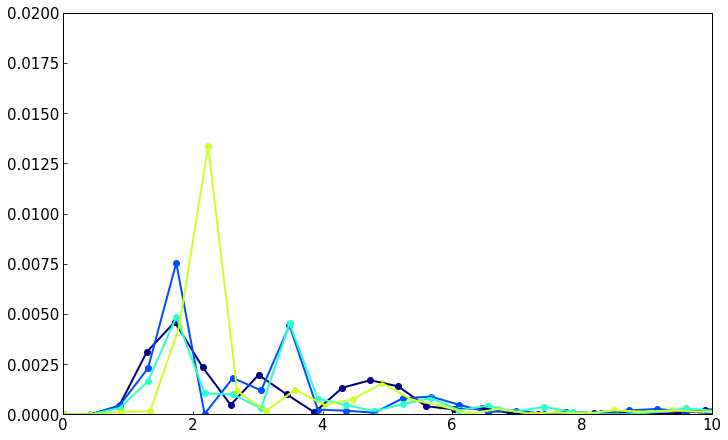

In [112]:
fig = plt.figure(figsize=(10,6),constrained_layout=True)
ax = fig.add_subplot(111)
colors = iter(jet(np.linspace(0,1,6)))
for num,angle in zip([7,11,15,19],[32.5,45,50,57]):
    color = next(colors)

    x = [1/x/np.cos(angle/180*np.pi) for x in dt[dt.num==num].bf]
#     x = [x for x in dt[dt.num==num].bf]
    x = np.array(x)
    y = dt[dt.num==num].sxx

    xc = x[x<0.6]
    yc = y[x<0.6]

    X,Y = interp_user(xc,cutout_bkgd(xc,yc),1000)
    frq,fft = FFT_bs(X,Y)
    ax.scatter(frq*e0/h0/1e15,abs(fft)**2,color=color)
    ax.plot(frq*e0/h0/1e15,abs(fft)**2,color=color)
#     ax.plot(X,Y)
    # plt.plot(X,Y)
    ax.set_xlim(0,10)
    ax.set_ylim(0,2e-2)


Text(0.5, 0, '$U_{TG}^{*}$ (V)')

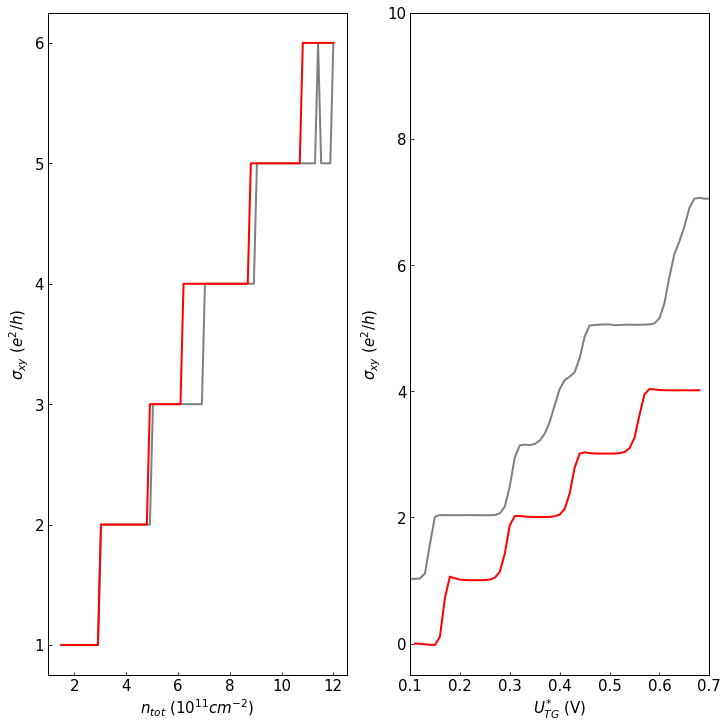

In [386]:
vf=0.5e6
gfactor=28
sigma=1e-3*e0


Erange = np.linspace(-0.03*e0,0.03*e0,60)


colors = iter(jet(np.linspace(0,1,c_num)))

fig = plt.figure(figsize=(10,10),constrained_layout=True)
gs = fig.add_gridspec(1,2)
ax1,ax2= [fig.add_subplot(x) for x in gs]

# simulation for double-QHE systems in tilted magnetic field
c_num = 90
for Bfield,angle,color in zip([8.26,31],[0,75],['grey','r']):
    count_ts = []
    count_bs = []
    
    for density_topsurface,density_bottomsurface in zip([x for x in np.linspace(8e15,0.5e15,c_num)],
                    np.linspace(4e15,1e15,c_num)):
       
        Ets = -hbar*vf*(4*np.pi*density_topsurface)**0.5
        Ebs = -hbar*vf*(4*np.pi*density_bottomsurface)**0.5
        Nmax = 20
        total_density = density_topsurface+density_bottomsurface
        
        llenergy_top_surface,llenergy_bottom_surface,_,_ = llenergy_generator(Ets,Ebs,0,Bfield,angle,Nmax,vf,gfactor)

        IDOS_B = fastIntegral_electron_DOS(Erange,Bfield,sigma,angle,llenergy_top_surface,llenergy_bottom_surface)


        # the chemical potential, the equal-density line
        chemical_potential = find_energy_bydensity(total_density,Bfield,IDOS_B,Erange)

        # count the number of Landau levels from each bands below the chemical potential 
        count_ts.append(sum([boolean_fun(chemical_potential>x) for x in llenergy_top_surface]))
        count_bs.append(sum([boolean_fun(chemical_potential>x) for x in llenergy_bottom_surface]))
        
    
    ax1.plot([(x+y)/1e15 for x,y in zip(np.linspace(9e15,0.5e15,c_num),np.linspace(3e15,1e15,c_num))],
    [x+y-1 for x,y in zip(count_ts,count_bs)],color = color)

# ax1.set_ylim(-0.5,5)
# ax1.set_xlim(3,12)
ax1.set_ylabel('$\sigma_{xy}$ $(e^2/h)$')
ax1.set_xlabel('$n_{tot}$ $(10^{11} cm^{-2})$')


dir1 = r'C:\LAB\Paper\draft_hgmnte\local data\QC0464 AD ICP I\120mK\fanchart\Fanchart_Ubg0V_Utg_0_to_m1p2V_B_to_10T (01)'
dir2 = r'C:\LAB\Paper\draft_hgmnte\local data\QC0464 AD ICP I\120mK\fanchart\Fanchart_Ubg0V_Utg_0_to_m1p2V_B_10 to_16T (01)'
step_0464 = read_file(dir1)+read_file(dir2)
ucols = (0,3,4,5)
nms = ['gate','uxy','uxx','curr']
spr = 34
Ref = 9998
Fanc_0464 = dir2fnm(dir1)+dir2fnm(dir2)
Fanc_DJ_0464 = Datafc(Fanc_0464,step_0464,ucols,nms,spr,Ref)
fc, dt = Fanc_DJ_0464.getdata()
ax2.plot(dt[dt.bf==8.26].gate+0.75,dt[dt.bf==8.26].sxy/e0**2*h0,color='grey')


ref = 9891.6
spr = 0
ucols = (0,2,3,4,5,6,7,8,9)
nms = ['gate','curr_x','curr_y','uxx_x','uxx_y','uxy_x','uxy_y','temp','temp_r']
AspRatio = 3
tgs_fnm_varB_Gr = dir2fnm(r'C:\LAB\Paper\draft_hgmnte\local data\QC0464 AD ICP I\highfield(Grenoble)\Gatesweeps\New measurement configuration\TG Sweep')

databundle = pd.DataFrame()
steps = [73,84,90]
for i in range(len(tgs_fnm_varB_Gr)):
    data = pd.read_csv(tgs_fnm_varB_Gr[i], sep=" ",skiprows=spr, usecols=ucols, names=nms, header=None)    
    data['rxx'] = (data.uxx_x**2+data.uxx_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5/100
    data['rxy'] = (data.uxy_x**2+data.uxy_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*[pos_neg(x) for x in data.uxy_x]/100
    data['sxx'] = data['rxx']/AspRatio/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['sxy'] = data['rxy']/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['bf'] = steps[i]
    databundle = databundle.append(data)
dt = databundle 
ax2.plot(dt[dt.bf==73].gate+0.68,dt[dt.bf==73].sxy,color='r')
ax2.set_ylim(-0.5,10)
ax2.set_xlim(0.1,0.7)
ax2.set_ylabel('$\sigma_{xy}$ $(e^2/h)$')
ax2.set_xlabel('$U_{TG}^{*}$ (V)')
    

1 start with topsurface density 1.3, bottomsurface density 2.3 and vps density 40.0
2 start with topsurface density 1.2833333333333332, bottomsurface density 2.3 and vps density 40.0
3 start with topsurface density 1.2666666666666668, bottomsurface density 2.3 and vps density 40.0
4 start with topsurface density 1.25, bottomsurface density 2.3 and vps density 40.0
5 start with topsurface density 1.2333333333333332, bottomsurface density 2.3 and vps density 40.0
6 start with topsurface density 1.2166666666666668, bottomsurface density 2.3 and vps density 40.0
7 start with topsurface density 1.2, bottomsurface density 2.3 and vps density 40.0
8 start with topsurface density 1.1833333333333333, bottomsurface density 2.3 and vps density 40.0
9 start with topsurface density 1.1666666666666667, bottomsurface density 2.3 and vps density 40.0
10 start with topsurface density 1.15, bottomsurface density 2.3 and vps density 40.0
11 start with topsurface density 1.1333333333333333, bottomsurface 

80 start with topsurface density 0.5641509433962264, bottomsurface density 2.3 and vps density -1.1018867924528302
81 start with topsurface density 0.5619496855345912, bottomsurface density 2.3 and vps density -1.12937106918239
82 start with topsurface density 0.559748427672956, bottomsurface density 2.3 and vps density -1.1568553459119497
83 start with topsurface density 0.5575471698113208, bottomsurface density 2.3 and vps density -1.1843396226415095
84 start with topsurface density 0.5553459119496855, bottomsurface density 2.3 and vps density -1.2118238993710693
85 start with topsurface density 0.5531446540880504, bottomsurface density 2.3 and vps density -1.239308176100629
86 start with topsurface density 0.5509433962264151, bottomsurface density 2.3 and vps density -1.2667924528301888
87 start with topsurface density 0.5487421383647799, bottomsurface density 2.3 and vps density -1.2942767295597486
88 start with topsurface density 0.5465408805031446, bottomsurface density 2.3 and v

152 start with topsurface density 0.4056603773584906, bottomsurface density 2.3 and vps density -3.080754716981132
153 start with topsurface density 0.40345911949685537, bottomsurface density 2.3 and vps density -3.108238993710692
154 start with topsurface density 0.40125786163522015, bottomsurface density 2.3 and vps density -3.135723270440252
155 start with topsurface density 0.3990566037735849, bottomsurface density 2.3 and vps density -3.1632075471698116
156 start with topsurface density 0.3968553459119497, bottomsurface density 2.3 and vps density -3.190691823899371
157 start with topsurface density 0.3946540880503145, bottomsurface density 2.3 and vps density -3.218176100628931
158 start with topsurface density 0.39245283018867927, bottomsurface density 2.3 and vps density -3.245660377358491
159 start with topsurface density 0.390251572327044, bottomsurface density 2.3 and vps density -3.2731446540880507
160 start with topsurface density 0.3880503144654088, bottomsurface density 

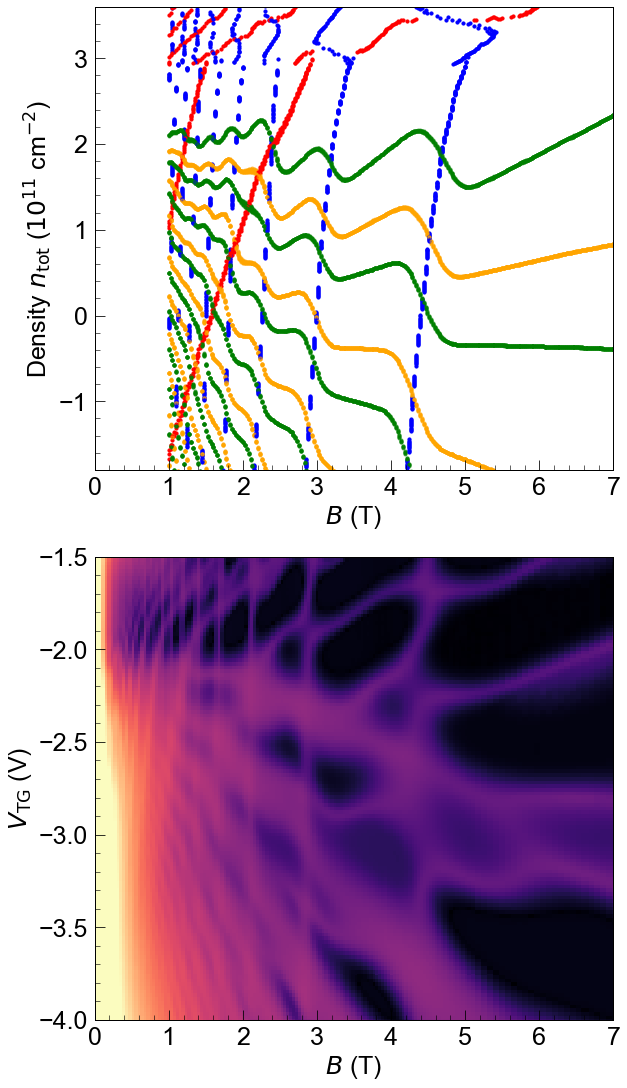

In [6]:
llfan_simu = TBLLsimu(vf=0.5e6,gfactor=28,sigma=1e-3*e0,meff=-0.2)

# Erange = np.linspace(-0.03*e0,0.03*e0,30)
Erange = np.linspace(-0.01*e0,0.02*e0,30)
Nmax = 20

fig = plt.figure(figsize=(8.6,15),constrained_layout=True)
gs = fig.add_gridspec(2,1)
ax1,ax2 = [fig.add_subplot(x) for x in gs]
# ax1 = fig.add_subplot(111)

x = np.linspace(-5,0,251)
y = ndata['bf'].unique()
sxx = fc_interp(y, x,ndata.sxx,False)
sxy = fc_interp(y, x,ndata.sxy,False)
diff = fc_interp(y, x, ndata.diffsxy.dropna())

sxy_r = np.round(sxy/e0**2*h0)*e0**2/h0
mpp_sxx = ax2.imshow(abs(sxx.transpose()/e0**2*h0)**(1/3), aspect='auto', interpolation='none', extent=extents(y) + extents(x),origin='low', cmap='magma', vmin=0, vmax=4)
# cbaxes2 = fig.add_axes([1,0.1,0.01,0.2])
# cb = fig.colorbar(mpp_sxx,cax=cbaxes2,label= '$\sigma_{xx}^{1/3}$ $(e^2/h)^{1/3}$',orientation = 'vertical',pad = 10, ticks = [x for x in range(0,10)])
ax2.set_ylim(-4,-1.5)
ax2.set_xlabel('$B$ (T)')

ax2.set_xlim(0,7)
[ax.set_xticks(np.linspace(0,7,8)) for ax in [ax1,ax2]]
ax2.set_ylabel('$V_\mathrm{TG}$ (V)')




i = 0

# for den_top,den_bot,den_vps in zip([x for x in np.linspace(1.3e15,0.65e15,20)]+[x for x in np.linspace(0.65e15,0.3e15,40)],[2.3e15]*60,[-4e16]*20+[x for x in np.linspace(0.1e15,4.4e15,40)]):
for den_top,den_bot,den_vps in zip([x for x in np.linspace(1.3e15,0.65e15,40)]+[x for x in np.linspace(0.65e15,0.3e15,160)],[2.3e15]*200,[-4e16]*40+[x for x in np.linspace(0.03e15,4.4e15,160)]):


    i+=1
    print('{} start with topsurface density {}, bottomsurface density {} and vps density {}'.format(i,den_top/1e15,den_bot/1e15,-den_vps/1e15))
    if den_vps<0:
        Brange = np.linspace(1,7,240)
        total_den = den_top+den_bot
        range_plot = [total_den-0.02e15,total_den+0.02e15]
        
        N_ts,N_bs = llfan_simu.get_ll_den(0,Brange,Erange,Nmax,den_top,den_bot)
        for n_ts in np.transpose(N_ts):
            ax1.scatter(Brange[range_pick(n_ts,range_plot[0],range_plot[1])],n_ts[range_pick(n_ts,range_plot[0],range_plot[1])]/1e15,color = 'r',s=10)
        for n_bs in np.transpose(N_bs):
            ax1.scatter(Brange[range_pick(n_bs,range_plot[0],range_plot[1])],n_bs[range_pick(n_bs,range_plot[0],range_plot[1])]/1e15,color = 'b',s=10)
#         ax1.axhline(y=total_den/1e15,linestyle='--',linewidth=1)
    else:
        Brange = np.linspace(1,7,240)
        total_den = den_top+den_bot-den_vps
        range_plot = [total_den-0.1e15,total_den+0.1e15]
        N_ts,N_bs,N_vpsup,N_vpsdown = llfan_simu.get_ll_den(0,Brange,Erange,Nmax,den_top,den_bot,den_vps,True)
        for n_ts in np.transpose(N_ts):
            ax1.scatter(Brange[range_pick(n_ts,range_plot[0],range_plot[1])],n_ts[range_pick(n_ts,range_plot[0],range_plot[1])]/1e15,color = 'r',s=10)
        for n_bs in np.transpose(N_bs):
            ax1.scatter(Brange[range_pick(n_bs,range_plot[0],range_plot[1])],n_bs[range_pick(n_bs,range_plot[0],range_plot[1])]/1e15,color = 'b',s=10)
        for n_vpsup in np.transpose(N_vpsup):
            ax1.scatter(Brange[range_pick(n_vpsup,range_plot[0],range_plot[1])],n_vpsup[range_pick(n_vpsup,range_plot[0],range_plot[1])]/1e15,color = 'orange',s=10,alpha = 0.5)
        for n_vpsdown in np.transpose(N_vpsdown):
            ax1.scatter(Brange[range_pick(n_vpsdown,range_plot[0],range_plot[1])],n_vpsdown[range_pick(n_vpsdown,range_plot[0],range_plot[1])]/1e15,color = 'green',s=10,alpha = 0.5)     
    
#         ax1.axhline(y=total_den/1e15,linestyle='--',linewidth=1)
ax1.set_xlabel('$B$ (T)')
ax1.set_ylabel('Density $n_\mathrm{tot}$ ($10^{11}$ cm$^{-2}$)')

ax1.set_ylim(-1.8,3.6)
ax1.set_xlim(0,7)
plt.savefig('figures/figS3')

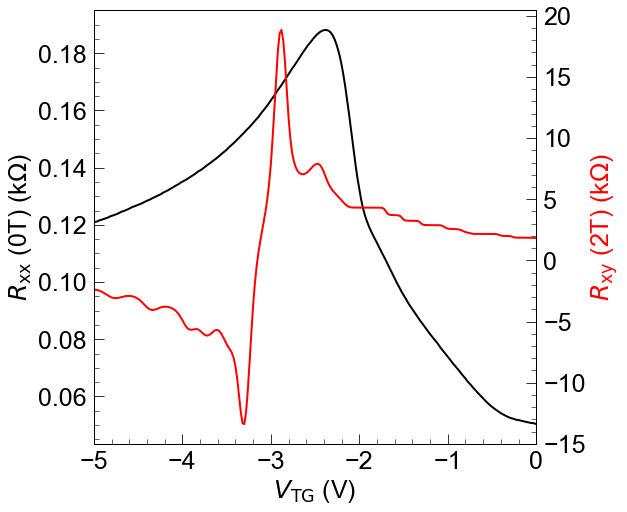

In [3]:
fig = plt.figure(figsize=(8.6,7),constrained_layout=True)
ax = fig.add_subplot(111)
ln1 = ax.plot(ndata[is_close(ndata.bf,0)].gate,ndata[is_close(ndata.bf,0)].rxx/1e3,'k-',label='$R_{xx}$ (B=0T)')
ax1 = ax.twinx()
ln2 = ax1.plot(ndata[is_close(ndata.bf,2)].gate,ndata[is_close(ndata.bf,2)].rxy/1e3,'r-',label = '$R_{xy}$ (B=2T)')
ax.set_xlabel('$V_\mathrm{TG}$ (V)')
ax.set_ylabel('$R_\mathrm{xx}$ (0T) (k$\Omega$)')
ax1.set_ylabel('$R_\mathrm{xy}$ (2T) (k$\Omega$)',color='r')
ax.set_xticks([-5,-4,-3,-2,-1,0])
# ln = ln1+ln2
# labels = [l.get_label() for l in ln]
# ax.legend(ln, labels, loc=[0.3,0],frameon=False)
ax.set_xlim(-5,0)
plt.savefig('figures/figS10')


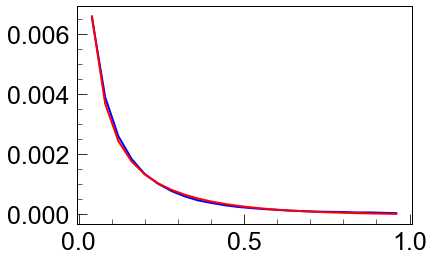

The fitCov is [[ 2.30567984e-26  2.68886068e-13 -1.72135124e-28  1.38781569e-15]
 [ 2.68886068e-13  3.13572764e+00 -2.00755519e-15  1.63725507e-02]
 [-1.72135124e-28 -2.00755519e-15  1.28842116e-30 -1.50544606e-17]
 [ 1.38781569e-15  1.63725507e-02 -1.50544606e-17  6.73446506e-03]]
1.9900371625147335 55.794566772105675 -2.4610057631919093 1.9261085180667668


In [308]:
data_p = df_range(ndata,'bf',[0,1])
from pd_Hallfit import H2nd_ft
for step in [-3]:
    bf = data_p[is_close(data_p.gate,step)].bf
    rxx = data_p[is_close(data_p.gate,step)].rxx
    rxy = data_p[is_close(data_p.gate,step)].rxy
    ne,me,nh,mh= H2nd_ft(bf,rxx,rxy)
    print(ne/1e15,me,nh/1e15,mh)

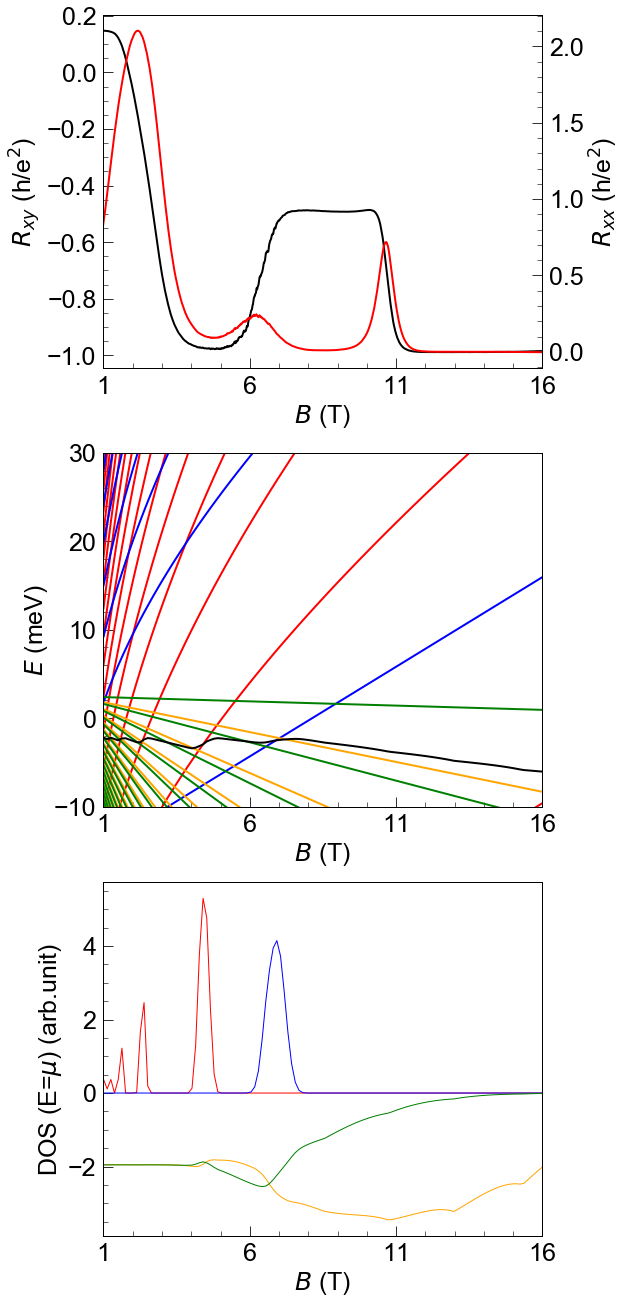

In [7]:
llfan_simu = TBLLsimu(vf=0.5e6,gfactor=35,sigma=0.5e-3*e0,meff=-0.15)
Ref = 9998
spr = 30
ucols = (0,1,2,3)
steps = [-0.4,-0.5,-0.55,-0.6,-0.65,-0.7,-0.75,-0.8,-0.85,-0.9]
nms = ['bf','curr','uxy','uxx']
dir1 = cwp+r'\local data\QC0464 AD ICP I\120mK\bsweep\bs_utg_m0p4_to_m0p9_ubg_0V  (01)'
bs_DJ_bg_0V_vartg_120mK_fine = Databs(dir2fnm(dir1),steps,ucols,nms,spr,Ref)
dt = bs_DJ_bg_0V_vartg_120mK_fine.getdata()
gate = -0.9
jet= plt.get_cmap('jet')

fig = plt.figure(figsize=(8.6,6*3),constrained_layout=True)
gs = fig.add_gridspec(3,1)
ax1,ax2,ax3 = [fig.add_subplot(x) for x in gs]
ax1.plot(dt[is_close(dt['gate'],gate)].bf,dt[is_close(dt['gate'],gate)].rxy*e0**2/h0,color='k')
ax4 = ax1.twinx()
ax4.plot(dt[is_close(dt['gate'],gate)].bf,dt[is_close(dt['gate'],gate)].rxx*e0**2/h0,color='r')


den_top=1.3e15
den_bot=0.2e15
den_vps=3.1e15
Brange = np.linspace(1,16,120)
Erange = np.linspace(-0.01*e0,0.02*e0,30)
Nmax = 20
angle = 0
sigma = 0.5e-3*e0
gate = -0.9


LL_ts,LL_bs,LL_vpsup,LL_vpsdown=llfan_simu.get_ll_en(angle,Brange,Nmax,den_top,den_bot,den_vps,True)
IDOS = llfan_simu.IDOS_generator(angle,Brange,Erange,LL_ts,LL_bs,LL_vpsup,LL_vpsdown)


for ll_ts in np.transpose(LL_ts):
    ax2.plot(Brange,ll_ts*1e3/e0,'r-')
for ll_bs in np.transpose(LL_bs):
    ax2.plot(Brange,ll_bs*1e3/e0,'b-')
for ll_vpsup in np.transpose(LL_vpsup):
    ax2.plot(Brange,ll_vpsup*1e3/e0,color='orange')
for ll_vpsdown in np.transpose(LL_vpsdown):
    ax2.plot(Brange,ll_vpsdown*1e3/e0,color='green')
    
ax2.plot(Brange,[find_energy_bydensity(den_top+den_bot-den_vps,B,IDOS_B,Erange)*1e3/e0 for B,IDOS_B in zip(Brange,IDOS)],linewidth=2,color='k')

mu = [find_energy_bydensity(den_top+den_bot-den_vps,B,IDOS_B,Erange) for B,IDOS_B in zip(Brange,IDOS)]
ax3.plot(Brange,[electron_density_of_state(E,B,sigma,angle,ll_ts,[])/1e36 for E,B,ll_ts in zip(mu,Brange,LL_ts)],linewidth=1,color='r')
ax3.plot(Brange,[electron_density_of_state(E,B,sigma,angle,[],ll_bs)/1e36 for E,B,ll_bs in zip(mu,Brange,LL_bs)],linewidth=1,color='b')
ax3.plot(Brange,[hole_density_of_state(E,B,sigma,angle,ll_up,[])/1e36 for E,B,ll_up in zip(mu,Brange,LL_vpsup)],linewidth=1,color='orange')
ax3.plot(Brange,[hole_density_of_state(E,B,sigma,angle,[],ll_down)/1e36 for E,B,ll_down in zip(mu,Brange,LL_vpsdown)],linewidth=1,color='green')


[ax.set_xlim(1,16) for ax in [ax1,ax2,ax3]]
ax2.set_ylim(-10,30)
[ax.set_xlabel('$B$ (T)') for ax in [ax1,ax2,ax3]]
[ax.set_xticks([1,6,11,16]) for ax in [ax1,ax2,ax3]]
ax1.set_ylabel('$R_{xy}$ (h/e$^2$)')
ax2.set_ylabel('$E$ (meV)')
ax3.set_ylabel('DOS (E=$\mu$) (arb.unit)')
ax4.set_ylabel('$R_{xx}$ (h/e$^2$)')
plt.savefig('figures/figS4')

Text(0, 0.5, 'Energy (meV)')

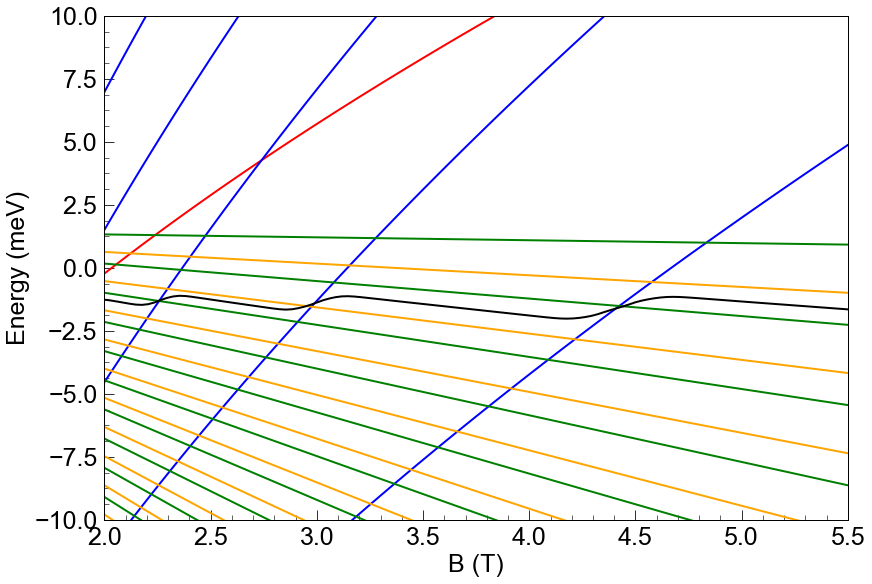

In [12]:
llfan_simu = TBLLsimu(vf=0.5e6,gfactor=28,sigma=0.5e-3*e0,meff=-0.2)
den_top=0.5e15
den_bot=2.3e15
den_vps=2.6e15
Brange = np.linspace(2,5.5,120)
Erange = np.linspace(-0.01*e0,0.02*e0,60)
Nmax = 20
angle = 0
sigma = 0.5e-3*e0
fig = plt.figure(figsize=(12,8),constrained_layout=True)
ax1 = fig.add_subplot(111)
LL_ts,LL_bs,LL_vpsup,LL_vpsdown=llfan_simu.get_ll_en(angle,Brange,Nmax,den_top,den_bot,den_vps,True)
IDOS = llfan_simu.IDOS_generator(angle,Brange,Erange,LL_ts,LL_bs,LL_vpsup,LL_vpsdown)


for ll_ts in np.transpose(LL_ts):
    ax1.plot(Brange,ll_ts*1e3/e0,'r-')
for ll_bs in np.transpose(LL_bs):
    ax1.plot(Brange,ll_bs*1e3/e0,'b-')
for ll_vpsup in np.transpose(LL_vpsup):
    ax1.plot(Brange,ll_vpsup*1e3/e0,color='orange')
for ll_vpsdown in np.transpose(LL_vpsdown):
    ax1.plot(Brange,ll_vpsdown*1e3/e0,color='green')
    
ax1.plot(Brange,[find_energy_bydensity(den_top+den_bot-den_vps,B,IDOS_B,Erange)*1e3/e0 for B,IDOS_B in zip(Brange,IDOS)],linewidth=2,color='k')

mu = [find_energy_bydensity(den_top+den_bot-den_vps,B,IDOS_B,Erange) for B,IDOS_B in zip(Brange,IDOS)]


[ax.set_xlim(2,5.5) for ax in [ax1]]
ax1.set_ylim(-10,10)
[ax.set_xlabel('B (T)') for ax in [ax1]]
# [ax.set_xticks([1,6,11,16]) for ax in [ax1,ax2]]
ax1.set_ylabel('Energy (meV)')

# plt.savefig('figures/p2_f7')

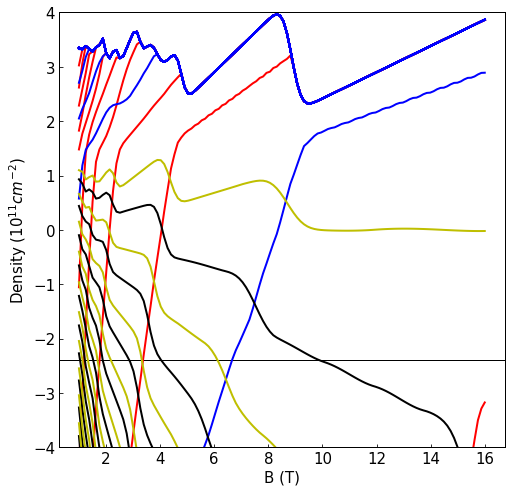

In [158]:
ax = llfan_simu.plot_ll_den(0,np.linspace(1,16,120),np.linspace(-0.01*e0,0.02*e0,30),20,den_top=1e15,den_bot=0.2e15,den_vps=3.6e15,threeband=True)

C:\Users\lwang\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\lwang\Anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\lwang\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Text(0, 0.5, '$U_{TG}$ (V)')

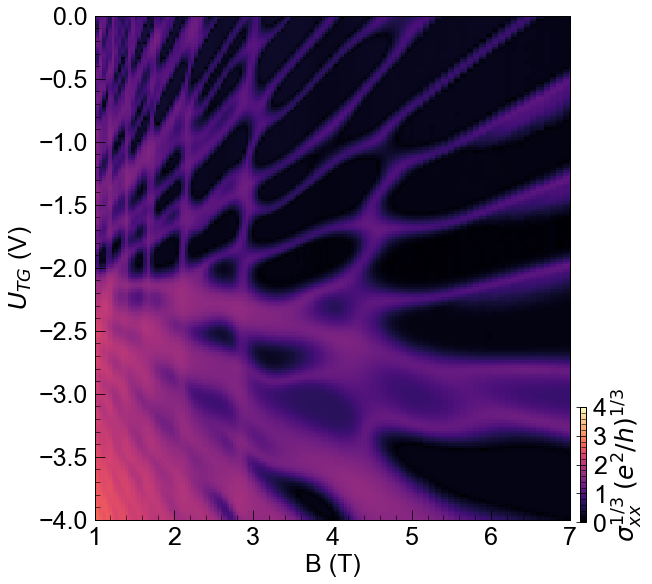

In [5]:
Ref = 9998
ucols = (0,1,2,3,6)
AspRatio = 3
nms = ['gate','bf','uxx','curr','uxy']
dir1 = r'\\System02\qt\Lixian\hgmnte\paper\QC0501_HBICP_gHB_Fanchart.txt'
data = pd.read_csv(dir1,sep=" ",skiprows=[x for x in range(0,35)]+[x for x in range(40195,61300)], usecols=ucols, names=nms, header=None)
# dir1 = r'\\System02\qt\Lixian\hgmnte\paper\QC0502_HBICP_gHB_Fanchart.txt'
# data = pd.read_csv(dir1,sep=" ",skiprows=[x for x in range(45)], usecols=ucols, names=nms, header=None)

bflist = data.bf.unique()
ndata = pd.DataFrame()
for bf in bflist:
    dt = data[is_close(data['bf'],bf,0.01)]
    dt.sort_values(by=['gate'])
    dt['rxx'] = dt.uxx/dt.curr*Ref
    dt['rxy'] = dt.uxy/dt.curr*Ref
    dt['sxy'] = dt['rxy']/((dt['rxx']/AspRatio)**2+dt['rxy']**2)
    dt['sxx'] = dt['rxx']/((dt['rxx']/AspRatio)**2+dt['rxy']**2)
    dt['diffsxy'] = dt['sxy'].diff()/0.02
    dt['beta'] = h0/e0**2/(dt['rxx']-dt['rxy'])
    ndata = ndata.append(dt)

    
fig = plt.figure(figsize=(8,8),constrained_layout=True)
ax = fig.add_subplot(111)   

x = np.linspace(-5,0,251)
y = ndata['bf'].unique()
sxx = fc_interp(y, x,ndata.sxx,False)
sxy = fc_interp(y, x,ndata.sxy,False)
diff = fc_interp(y, x, ndata.diffsxy.dropna())

sxy_r = np.round(sxy/e0**2*h0)*e0**2/h0
# mpp_dsxy = ax1.imshow(diff, aspect='auto', interpolation='none', extent=extents(x) + extents(y),origin='low', cmap='terrain', vmin=0, vmax=0.003)
mpp_sxx = ax.imshow(abs(sxx.transpose()/e0**2*h0)**(1/3), aspect='auto', interpolation='none', extent=extents(y) + extents(x),origin='low', cmap='magma', vmin=0, vmax=4)



# ax2.contour(y, x, sxy.transpose()/e0**2*h0, levels=2, linewidths=0.5, colors='k')
# cntr1 = ax2.contourf(y, x, sxy.transpose()/e0**2*h0 , levels=14, cmap="gist_ncar")

# fig.colorbar(cntr1, ax=ax2)

# cbaxes1 = fig.add_axes([1,0.75,0.01,0.2])
cbaxes2 = fig.add_axes([1,0.1,0.01,0.2])
# cb = fig.colorbar(mpp_dsxy,cax=cbaxes1,label= '$d\sigma_{xy}/dU_{TG}$ $(a.u.)$',orientation = 'vertical',pad = 10)
cb = fig.colorbar(mpp_sxx,cax=cbaxes2,label= '$\sigma_{xx}^{1/3}$ $(e^2/h)^{1/3}$',orientation = 'vertical',pad = 10, ticks = [x for x in range(0,10)])

# gate = -3.8

ax.set_ylim(-4,0)
ax.set_xlabel('B (T)')

ax.set_xlim(1,7)
ax.set_xticks(np.linspace(1,7,7))
ax.set_ylabel('$U_{TG}$ (V)')
# ax.axhline(y=gate,linestyle='-',color='w',linewidth = 1)


194190593816.7422

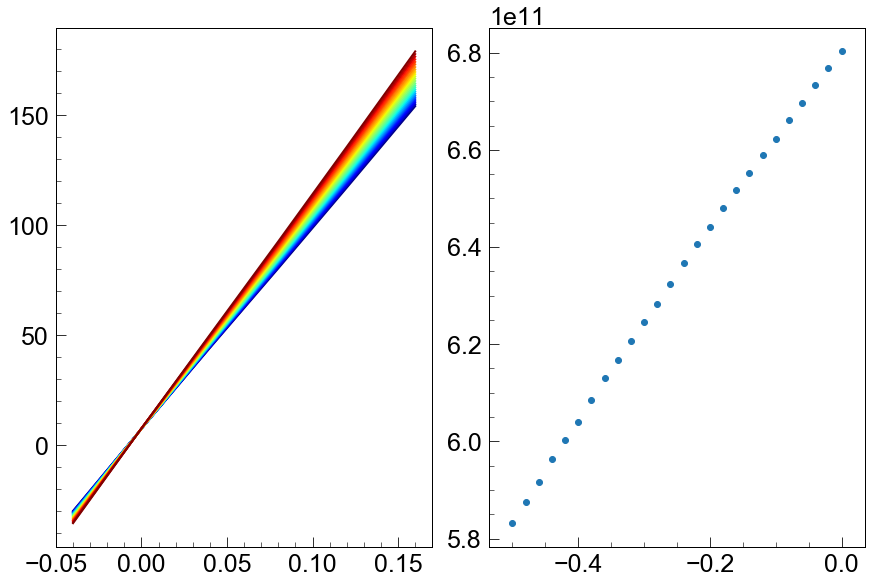

In [55]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
jet= plt.get_cmap('jet')
gs = fig.add_gridspec(1,2)
ax1,ax2 = [fig.add_subplot(x) for x in gs]
colors = iter(jet(np.linspace(0,1,26)))
Dens = []
dt = ndata[ndata.bf<0.2]
for index,gate in enumerate(np.linspace(0,-0.5,26)):
    color = next(colors)
    x = dt[is_close(dt['gate'],gate)].bf
    y = dt[is_close(dt['gate'],gate)].rxx
    z = dt[is_close(dt['gate'],gate)].rxy
    ax1.plot(x,z,color=color)
    den,mob = H1st_ft(x,y,z)
    Dens.append(den)
    
ax2.scatter(np.linspace(0,-0.5,26),Dens)
(max(Dens)-min(Dens))*2

Text(0, 0.5, '$|FFT|^2$(arb.unit)')

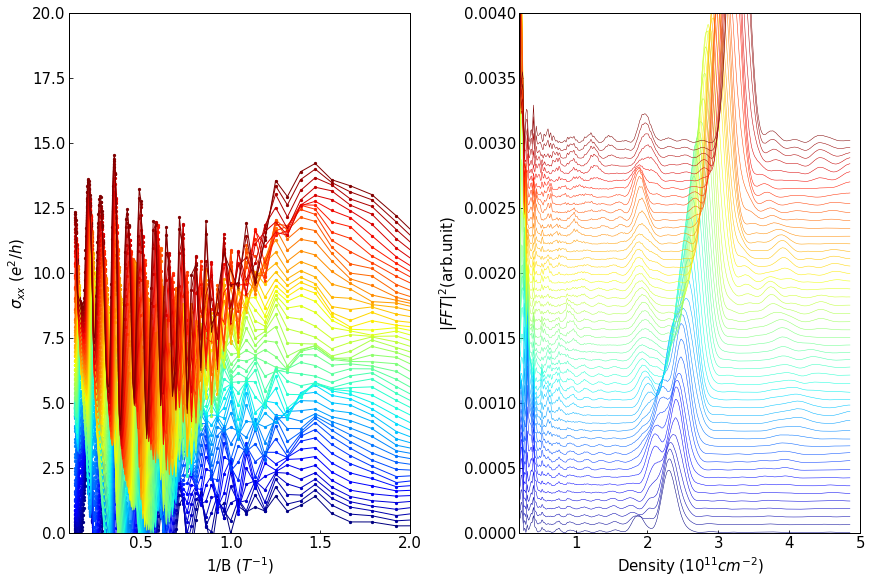

In [611]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(1,2)
ax1,ax2 = [fig.add_subplot(x) for x in gs]
colors = iter(jet(np.linspace(0,1,51)))
for index,gate in enumerate(np.linspace(-4,-5,51)):
    shift = index*0.2
    color = next(colors)
    x = ndata[is_close(ndata['gate'],gate)].bf
    y = ndata[is_close(ndata['gate'],gate)].sxx/e0**2*h0
    
    xc = x[x>0.01]
    yc = y[x>0.01]
    
    
    xdata = [1/xx for xx in xc]
    xdata = np.array(xdata)
    
    ydata = yc

#     ax.scatter([1./xx for xx in xs],ys+shift,color=color)
    ax1.plot(xdata,cutout_bkgd(xdata,ydata)+shift,color=color,linewidth=1)
    ax1.scatter(xdata,cutout_bkgd(xdata,ydata)+shift,color=color,s=5)

   
    X,Y = interp_user(xdata,cutout_bkgd(xdata,ydata),1000)
    frq,fft = FFT_bs(X,Y)
#     ax2.scatter(frq*e0/h0/1e15,abs(fft)**2+3e-4*shift,color=color,s=1)
    ax2.plot(frq*e0/h0/1e15,abs(fft)**2+3e-4*shift,color=color,linewidth=0.5)

# # [ax.axhline(y=h0/e0**2/1e3/n,linestyle='--',color='grey') for n in [3,4,5,6,7,8]]

ax1.set_xlim(0.1,2)
ax1.set_ylim(0,20)
ax1.set_xlabel('1/B ($T^{-1}$)')
ax1.set_ylabel('$\sigma_{xx}$ $(e^2/h)$')
ax2.set_ylim(0,0.004)
ax2.set_xlim(0.2,5)
ax2.set_xlabel('Density ($10^{11}cm^{-2}$)')
ax2.set_ylabel('$|FFT|^2$(arb.unit)')


(0, 3)

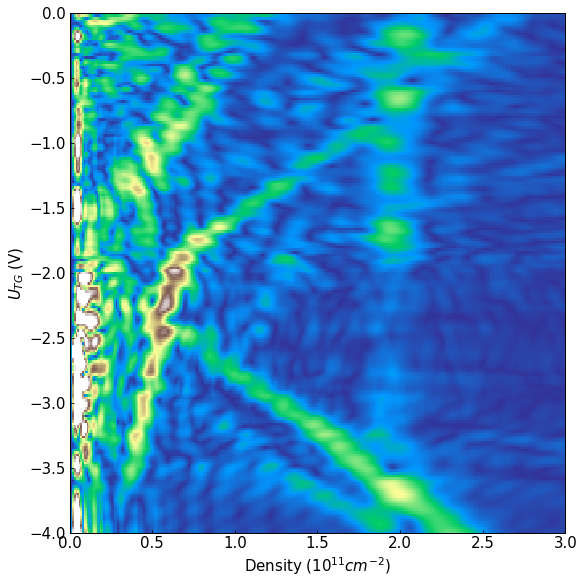

In [708]:
fig = plt.figure(figsize=(8,8),constrained_layout=True)

ax1 = fig.add_subplot(111)

gates = np.linspace(-4,0,201)
fft2d = []


for index,gate in enumerate(gates):
    x = ndata[is_close(ndata['gate'],gate)].bf
    y = ndata[is_close(ndata['gate'],gate)].sxx/e0**2*h0
    
    xc = x[x>0.01]
    yc = y[x>0.01]
    
    
    xdata = [1/xx for xx in xc]
    xdata = np.array(xdata)
    ydata = yc
   
    X,Y = interp_user(xdata,cutout_bkgd(xdata,ydata),1000)
    frq,fft = FFT_bs(X,Y)
#     ax2.scatter(frq*e0/h0/1e15,abs(fft)**2+3e-4*shift,color=color,s=1)
#     ax2.plot(frq*e0/h0/1e15,abs(fft)**2+3e-4*shift,color=color,linewidth=0.5)
    fft2d.append((abs(fft)/np.mean(abs(fft))))  # normalized amplitude of fft and the power square is for color coding.
    
    
n2d = e0 * frq / h0 / 1e15   
x_crd = n2d.tolist()
y_crd = [round(x, 3) for x in gates.tolist()]
ax1.imshow(fft2d, aspect='auto', interpolation='none', extent=(extents(x_crd) + extents(y_crd)), origin='cool',
                         cmap='terrain', vmin=0, vmax=10)
ax1.set_ylim([min(gates), max(gates)])
ax1.set_xlabel('Density ($10^{11}cm^{-2}$)')
ax1.set_ylabel('$U_{TG}$ (V)')
ax1.set_xlim(0,3)

In [586]:
from matplotlib.colors import LogNorm
set_pub()

fig = plt.figure(figsize=(15,9),constrained_layout=True)
gs = fig.add_gridspec(2,7)

ref = 9891.6
spr = 0
ucols = (0,2,3,4,5,6,7,8,9)
steps = np.linspace(31,15,17)
nms = ['gate','curr_x','curr_y','uxx_x','uxx_y','uxy_x','uxy_y','temp','temp_r']
AspRatio = 3

tgs_fnm_varB_Gr = dir2fnm(r'C:\LAB\local data\QC0464 AD ICP I\highfield(Grenoble)\Gatesweeps\New measurement configuration\TG Sweep\various B')[:-3]
databundle = pd.DataFrame()
rxx2D = pd.DataFrame()
sxy2D = pd.DataFrame()
for i in range(len(tgs_fnm_varB_Gr)):
    data = pd.read_csv(tgs_fnm_varB_Gr[i], sep=" ",skiprows=spr, usecols=ucols, names=nms, header=None)    
    data['rxx'] = (data.uxx_x**2+data.uxx_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5/100
    data['rxy'] = (data.uxy_x**2+data.uxy_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*[pos_neg(x) for x in data.uxy_x]/100
    data['sxx'] = data['rxx']/AspRatio/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['sxy'] = data['rxy']/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['bf'] = steps[i]
    rxx2D = rxx2D.append(data['rxx'])
    sxy2D = sxy2D.append(data['sxy'])
    databundle = databundle.append(data)
x = databundle['gate'].unique()+0.68
y = steps

dt = databundle
ax1 = plt.subplot(gs[0,3:5])
mpp = ax1.imshow(rxx2D,aspect='auto', interpolation='none', extent=(extents(x) + extents(y)),origin='lower',norm=LogNorm(vmin=1000, vmax=1e8),
                 cmap='hot')
cbaxes = fig.add_axes([0.62, 1.01, 0.12, 0.01])
# cb = plt.colorbar(ax1, cax = cbaxes) = 
cb = fig.colorbar(mpp,cax=cbaxes,label= '$R_{xx}$ $(\Omega)$',orientation = 'horizontal',pad = 10, ticks = [1e4,1e5,1e6,1e7])
cbaxes.get_xaxis().set_ticks_position('top')
cbaxes.get_xaxis().set_label_position('top')

ax1.set_xlim(-0.3,0.3)
ax1.set_yticks([15,20,25,30])
ax1.tick_params(axis="y",direction="out",pad=10)
ax1.tick_params(axis="x",direction="out",pad=10)
ax1.minorticks_on()
ax1.tick_params(which='major', length=5, width=1, direction='out')
ax1.tick_params(which='minor', length=2, width=1, direction='out')
ax1.set_ylabel('$\mu_{0}H$ (T)')
ax1.set_xlabel('$\Delta U_{TG}$ (V)')


ax3 = plt.subplot(gs[0,0:3])
mpp = ax3.imshow(sxy2D,aspect='auto', interpolation='none', extent=(extents(x) + extents(y)),origin='lower',
                 cmap='terrain',vmin=-3, vmax=4)
cbaxes = fig.add_axes([0.1, 1.01, 0.25, 0.01])
# cb = plt.colorbar(ax1, cax = cbaxes) = 
cb = fig.colorbar(mpp,cax=cbaxes,label= '$\sigma_{xy}$ $(e^2/h)$',orientation = 'horizontal',pad = 10, ticks = [-2,-1,0,1,2,3])
cbaxes.get_xaxis().set_ticks_position('top')
cbaxes.get_xaxis().set_label_position('top')
ax3.set_xlim(-0.52,0.68)
ax3.set_xticks([-0.4,-0.2,0,0.2,0.4])
ax3.set_yticks([15,20,25,30])
ax3.tick_params(axis="y",direction="out",pad=10)
ax3.tick_params(axis="x",direction="out",pad=10)
ax3.minorticks_on()
ax3.tick_params(which='major', length=5, width=1, direction='out')
ax3.tick_params(which='minor', length=2, width=1, direction='out')
ax3.set_ylabel('$\mu_{0}H$ (T)')
ax3.set_xlabel('$\Delta U_{TG}$ (V)')




tgs_fnm_varB_Gr = dir2fnm(r'C:\LAB\local data\QC0464 AD ICP I\highfield(Grenoble)\Gatesweeps\New measurement configuration\TG Sweep\various B')
tgs_fnm_varangle_Gr=tgs_fnm_varB_Gr[-3:]
tgs_fnm_varangle_Gr.insert(0,tgs_fnm_varB_Gr[0])
databundle = pd.DataFrame()
steps = [0,73,84,90]
for i in range(len(tgs_fnm_varangle_Gr)):
    data = pd.read_csv(tgs_fnm_varangle_Gr[i], sep=" ",skiprows=spr, usecols=ucols, names=nms, header=None)    
    data['rxx'] = (data.uxx_x**2+data.uxx_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5/100
    data['rxy'] = (data.uxy_x**2+data.uxy_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*[pos_neg(x) for x in data.uxy_x]/100
    data['sxx'] = data['rxx']/AspRatio/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['sxy'] = data['rxy']/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['bf'] = steps[i]
    databundle = databundle.append(data)

dt = databundle
jet= plt.get_cmap('jet')
colors = iter(['b','r','k','grey'])
ax2 = plt.subplot(gs[1,3:5])
for idx,bf in enumerate([0,73,84,90]):
    color = next(colors)
    ax2.plot(dt[dt.bf==bf].gate+0.68,dt[dt.bf==bf].rxx,color=color)

ax5 = plt.subplot(gs[0,5:7])
ax6 = plt.subplot(gs[1,5:7])
ax5.plot(dt[dt.bf==73].gate+0.68,dt[dt.bf==73].rxx,color='r')
ax6.plot(dt[dt.bf==73].gate+0.68,dt[dt.bf==73].sxy,color='r')
    
    
dir1 = r'C:\LAB\local data\QC0464 AD ICP I\120mK\fanchart\Fanchart_Ubg0V_Utg_0_to_m1p2V_B_to_10T (01)'
dir2 = r'C:\LAB\local data\QC0464 AD ICP I\120mK\fanchart\Fanchart_Ubg0V_Utg_0_to_m1p2V_B_10 to_16T (01)'
def read_file(directory):
    filenames = dir2fnm(directory)
    num_list = [0]*len(filenames)
    for i,fnm in enumerate(filenames):
        fnm_strip = fnm.split()
        fnm_strip = fnm_strip[-2].split('d')
        num_str = fnm_strip[-1].replace('T','').replace(',','.')
        num_list[i] = float(num_str)
    return num_list

step_0464 = read_file(dir1)+read_file(dir2)
 
ucols = (0,3,4,5)
nms = ['gate','uxy','uxx','curr']
spr = 34
Ref = 9998
Fanc_0464 = dir2fnm(r'C:\LAB\local data\QC0464 AD ICP I\120mK\fanchart\Fanchart_Ubg0V_Utg_0_to_m1p2V_B_to_10T (01)')+dir2fnm(r'C:\LAB\local data\QC0464 AD ICP I\120mK\fanchart\Fanchart_Ubg0V_Utg_0_to_m1p2V_B_10 to_16T (01)')
Fanc_DJ_0464 = Datafc(Fanc_0464,step_0464,ucols,nms,spr,Ref)
fc, dt = Fanc_DJ_0464.getdata()


ax2.set_ylim(1e3,3e6)
ax2.set_xlim(-0.3,0.3)
ax2.set_yscale('log')
ax2.set_ylabel('$R_{xx}$ $(\Omega)$')
ax2.set_xlabel('$\Delta U_{TG}$ (V)')
ax2.tick_params(axis="y",direction="out",pad=10)
ax2.tick_params(axis="x",direction="out",pad=10)
ax2.minorticks_on()
ax2.tick_params(which='major', length=5, width=1, direction='out')
ax2.tick_params(which='minor', length=2, width=1, direction='out')


ax5.plot(dt[dt.bf==8.26].gate+0.75,dt[dt.bf==8.26].rxx,color='grey')
ax6.plot(dt[dt.bf==8.26].gate+0.75,dt[dt.bf==8.26].sxy/e0**2*h0,color='grey')


ax5.set_ylim(1e2,1e7)
ax5.set_yscale('log')
ax6.set_ylim(-5,5)
ax5.set_xlabel('$\Delta U_{TG}$ (V)')
ax5.set_ylabel('$R_{xx}$ ($\Omega$)')
ax6.set_xlabel('$\Delta U_{TG}$ (V)')
ax6.set_ylabel('$\sigma_{xy}$ ($e^2/h$)')
ax5.tick_params(axis="y",direction="out",pad=10)
ax5.tick_params(axis="x",direction="out",pad=10)
ax5.minorticks_on()
ax5.tick_params(which='major', length=5, width=1, direction='out')
ax5.tick_params(which='minor', length=2, width=1, direction='out')
ax6.tick_params(axis="y",direction="out",pad=10)
ax6.tick_params(axis="x",direction="out",pad=10)
ax6.minorticks_on()
ax6.tick_params(which='major', length=5, width=1, direction='out')
ax6.tick_params(which='minor', length=2, width=1, direction='out')



ref = 9891.6
spr = 0
ucols = (0,1,2,3,4,5,6,7,8)
tot_num = 11
steps = np.linspace(1,tot_num,tot_num)
nms = ['bf','curr_x','curr_y','uxx_x','uxx_y','uxy_x','uxy_y','temp','temp_r']
AspRatio = 3

bs_fnm = dir2fnm(r'C:\LAB\local data\QC0464 AD ICP I\highfield(Grenoble)\Hallmeasurements')
databundle = pd.DataFrame()
for i in range(len(bs_fnm)):
    data = pd.read_csv(bs_fnm[i], sep=" ",skiprows=spr, usecols=ucols, names=nms, header=None)
    if i>5:
        data['rxx'] = (data.uxx_x**2+data.uxx_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5/100
        data['rxy'] = (data.uxy_x**2+data.uxy_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*[pos_neg(x) for x in data.uxy_x]/100
    else:
        data['rxx'] = (data.uxx_x**2+data.uxx_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*ref
        data['rxy'] = (data.uxy_x**2+data.uxy_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*ref*[pos_neg(x) for x in data.uxy_x]
    data['sxx'] = data['rxx']/AspRatio/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['sxy'] = data['rxy']/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['num'] = steps[i]
    databundle = databundle.append(data)
    
dt = databundle
ax4 = plt.subplot(gs[1,0:3])
ax7 = ax4.twinx()
ax4.plot(dt[dt.num==1].bf,dt[dt.num==1].rxy/1e3,color='r')
ax7.plot(dt[dt.num==2].bf,dt[dt.num==2].rxy/1e3,color='grey')

ax4.set_xlabel('$\mu_{0}H$ (T)')
ax4.set_ylabel('$R_{xy}$ $(k\Omega)$')
ax4.tick_params(axis="y",direction="out",pad=10)
ax4.tick_params(axis="x",direction="out",pad=10)
ax4.minorticks_on()
ax4.tick_params(which='major', length=5, width=1, direction='out')
ax4.tick_params(which='minor', length=2, width=1, direction='out')
ax4.set_xlim(0,30)
ax7.set_ylabel('$R_{xy}$ $(k\Omega)$')
# plt.savefig('figures/figB1')

KeyError: 'gate'

<Figure size 1080x648 with 0 Axes>

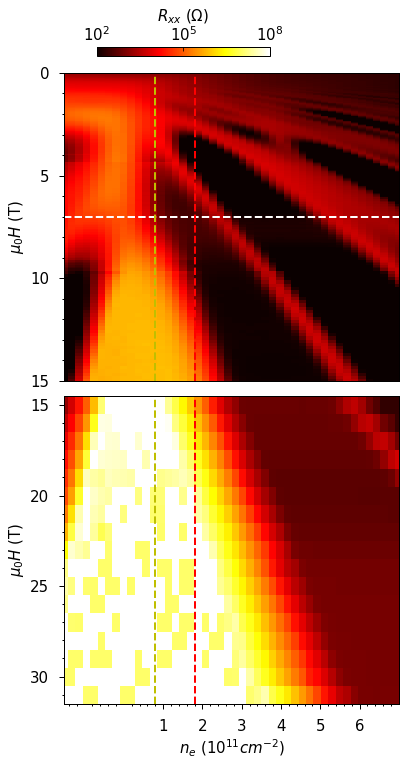

In [23]:
import matplotlib as mpl
ref = 9891.6
spr = 0
ucols = (0,2,3,4,5,6,7,8,9)
steps = np.linspace(31,15,17)
nms = ['gate','curr_x','curr_y','uxx_x','uxx_y','uxy_x','uxy_y','temp','temp_r']
AspRatio = 3

tgs_fnm_varB_Gr = dir2fnm(r'C:\LAB\local data\QC0464 AD ICP I\highfield(Grenoble)\Gatesweeps\New measurement configuration\TG Sweep\various B')[:-3]
databundle = pd.DataFrame()
rxx2D = pd.DataFrame()
sxy2D = pd.DataFrame()
for i in range(len(tgs_fnm_varB_Gr)):
    data = pd.read_csv(tgs_fnm_varB_Gr[i], sep=" ",skiprows=spr, usecols=ucols, names=nms, header=None)    
    data['rxx'] = (data.uxx_x**2+data.uxx_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5/100
    data['rxy'] = (data.uxy_x**2+data.uxy_y**2)**0.5/(data.curr_x**2+data.curr_y**2)**0.5*[pos_neg(x) for x in data.uxy_x]/100
    data['sxx'] = data['rxx']/AspRatio/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['sxy'] = data['rxy']/((data['rxx']/AspRatio)**2+data['rxy']**2)/e0**2*h0
    data['bf'] = steps[i]
    rxx2D = rxx2D.append(data['rxx'])
    sxy2D = sxy2D.append(data['sxy'])
    databundle = databundle.append(data)
x = databundle['gate'].unique()+0.68
x = [(xx+0.02)*(14.6-0.4)/0.75 for xx in x]
y = steps


fig = plt.figure(figsize=(6,12),constrained_layout=True)
gs = fig.add_gridspec(2,1)
ax1 = plt.subplot(gs[1,0])

plt.subplots_adjust(bottom=0.15, hspace=0.05)


# X, Y = np.meshgrid(x, y)

# CS = ax1.contour(X, Y, rxx2D/1e3,[10],cmap=mpl.colors.ListedColormap(['b']),linewidths=3,linestyles='solid')

mpp = ax1.imshow(rxx2D,aspect='auto', interpolation='none', extent=(extents(x) + extents(y)),origin='lower',norm=LogNorm(vmin=1e2, vmax=1e8)
                 ,cmap='hot')
# cbaxes = fig.add_axes([0.32, 1.01, 0.5, 0.01])
# # cb = plt.colorbar(ax1, cax = cbaxes) = 
# cb = fig.colorbar(mpp,cax=cbaxes,label= '$R_{xx}$ $(k\Omega)$',orientation = 'horizontal',pad = 10, ticks = [1e2,1e3,1e4,1e5,1e6,1e7])
# cbaxes.get_xaxis().set_ticks_position('top')
# cbaxes.get_xaxis().set_label_position('top')


ax1.set_yticks([15,20,25,30])


ucols = (0,3,4,5)
spr = 34
Ref = 9998

dir1 = r'C:\LAB\local data\QC0464 AD ICP I\120mK\fanchart\Fanchart_Ubg0V_Utg_0_to_m1p2V_B_to_10T (01)'
dir2 = r'C:\LAB\local data\QC0464 AD ICP I\120mK\fanchart\Fanchart_Ubg0V_Utg_0_to_m1p2V_B_10 to_16T (01)'
step_0464 = read_file(dir1)+read_file(dir2)
Fanc_fnm_Ubg_0V = dir2fnm(dir1)+dir2fnm(dir2)
Fanc_DJ_Ubg_0V = Datafc(Fanc_fnm_Ubg_0V,step_0464,ucols,['gate','uxy','uxx','curr'],spr,Ref)

ax2 = plt.subplot(gs[0,0])

fc, data = Fanc_DJ_Ubg_0V.getdata()
x = fc['x']+0.75
y = fc['y']
x = [(xx+0.02)*(14.6-0.4)/0.75 for xx in x]
interp = fc_interp(y, x, data.rxx.dropna(),False)
mpp = ax2.imshow(interp, aspect='auto', interpolation='none',origin='lower', extent=extents(x) + extents(y),norm=LogNorm(vmin=1e2, vmax=1e8),cmap='hot')
cbaxes = fig.add_axes([0.2, 0.9, 0.4, 0.01])
cb = fig.colorbar(mpp,cax=cbaxes,label= '$R_{xx}$ ($\Omega$)',orientation = 'horizontal',pad = 10)
cbaxes.get_xaxis().set_ticks_position('top')
cbaxes.get_xaxis().set_label_position('top')
X, Y = np.meshgrid(x, y)

for ax in [ax1,ax2]:

    
    ax.tick_params(axis="y",direction="out",pad=10)
    ax.tick_params(axis="x",direction="out",pad=10)
    ax.minorticks_on()
    ax.tick_params(which='major', length=5, width=1, direction='out')
    ax.tick_params(which='minor', length=2, width=1, direction='out')
    ax.set_ylabel('$\mu_{0}H$ (T)')
    ax.set_xlabel('$n_e$ $(10^{11}cm^{-2})$')
    ax.set_xlim((-0.1+0.02)*(14.6-0.4)/0.75,(0.35+0.02)*(14.6-0.4)/0.75)

ax2.set_ylim([15,0])
ax1.set_xticks([1,2,3,4,5,6])
# CS1 = ax2.contour(X, Y, interp/1e3,[10],cmap=mpl.colors.ListedColormap(['b']),linewidths=3,linestyles='solid')
ax2.axhline(y=7,color='w',linestyle='--')
ax2.axvline(x=0.8,color='y',linestyle='--')
ax2.axvline(x=1.8,color='r',linestyle='--')
ax1.axvline(x=0.8,color='y',linestyle='--')
ax1.axvline(x=1.8,color='r',linestyle='--')
# ax2.clabel(CS, [10], fmt='%1.0f',inline=1, fontsize=10)
ax2.get_xaxis().set_visible(False)
ax2.set_yticks([0,5,10,15])